<a href="https://colab.research.google.com/github/BelloBer/Landslide-Detection/blob/version-control/improvedBlock5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landslide Detection Challenge - Starter Notebook

Welcome to the Landslide Detection Challenge! This notebook will guide you through:
1. Loading and exploring the multi-band dataset provided in `.npy` format.
2. Visualizing the multi-band satellite data and understanding label distribution.
3. Building and evaluating a baseline model to classify landslide and non-landslide images.

Let’s get started with loading and understanding the data!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Block 1: Import Libraries

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Explanation
We import the required libraries:
- **os**: for file and directory handling.
- **numpy**: for numerical operations, particularly for loading `.npy` files.
- **pandas**: for data handling with CSV files.
- **matplotlib.pyplot**: for visualizing data, such as label distributions.
- **sklearn.model_selection.train_test_split**: for splitting data into training and validation sets.
- **tensorflow.keras**: for building and training a neural network model.


## Block 2: Define Paths and Load CSV Files

In [ ]:
# Define paths for the dataset (remember to unzip the dataset first!)
#train_csv_path = 'data/Train.csv'  # Path to the training labels CSV file
#test_csv_path = 'data/Test.csv'    # Path to the test image IDs CSV file
#train_data_path = 'data/train_data'  # Folder where .npy train files are located
#test_data_path = 'data/test_data'    # Folder where .npy test files are located

#new ecode entry, trying to mount google drive

train_data = '/content/drive/My Drive/train_data1/'
test_data = '/content/drive/My Drive/test_data/'

train_csv = "/content/drive/My Drive/train_data1/Train.csv"
test_csv = "/content/drive/My Drive/test_data/Test.csv"


# Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv)
print("Train.csv:")
print(train_df.head())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0


In [ ]:
train_df.label.value_counts()

,count
label,
0,5892
1,1255


### Explanation
- **Define Paths**: Specify paths to `Train.csv`, `Test.csv`, and folders containing `.npy` files for training and testing images.
- **Load Train.csv**: We read the `Train.csv` file, which contains `ID` and `label` columns. The `label` is binary, indicating whether the image contains a landslide (1) or not (0).


## Block 3: Visualize Label Distribution

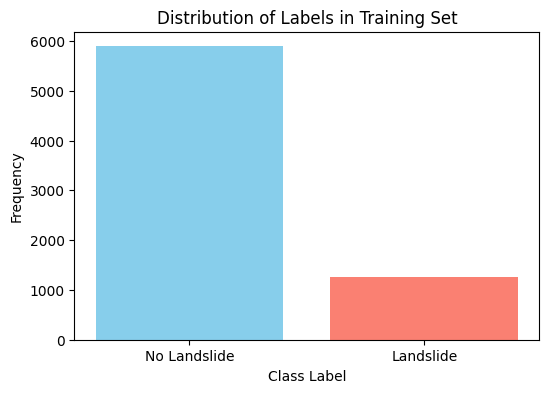

In [ ]:
# Check distribution of labels
label_counts = train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

### Explanation
This block visualizes the distribution of labels (landslide vs. non-landslide) in the training data.
- `value_counts()` shows the count of each class, and we use a bar chart to display these counts, which helps us understand if the dataset is balanced.


## Block 4: Load, Normalize, and Display Sample Multi-band Images

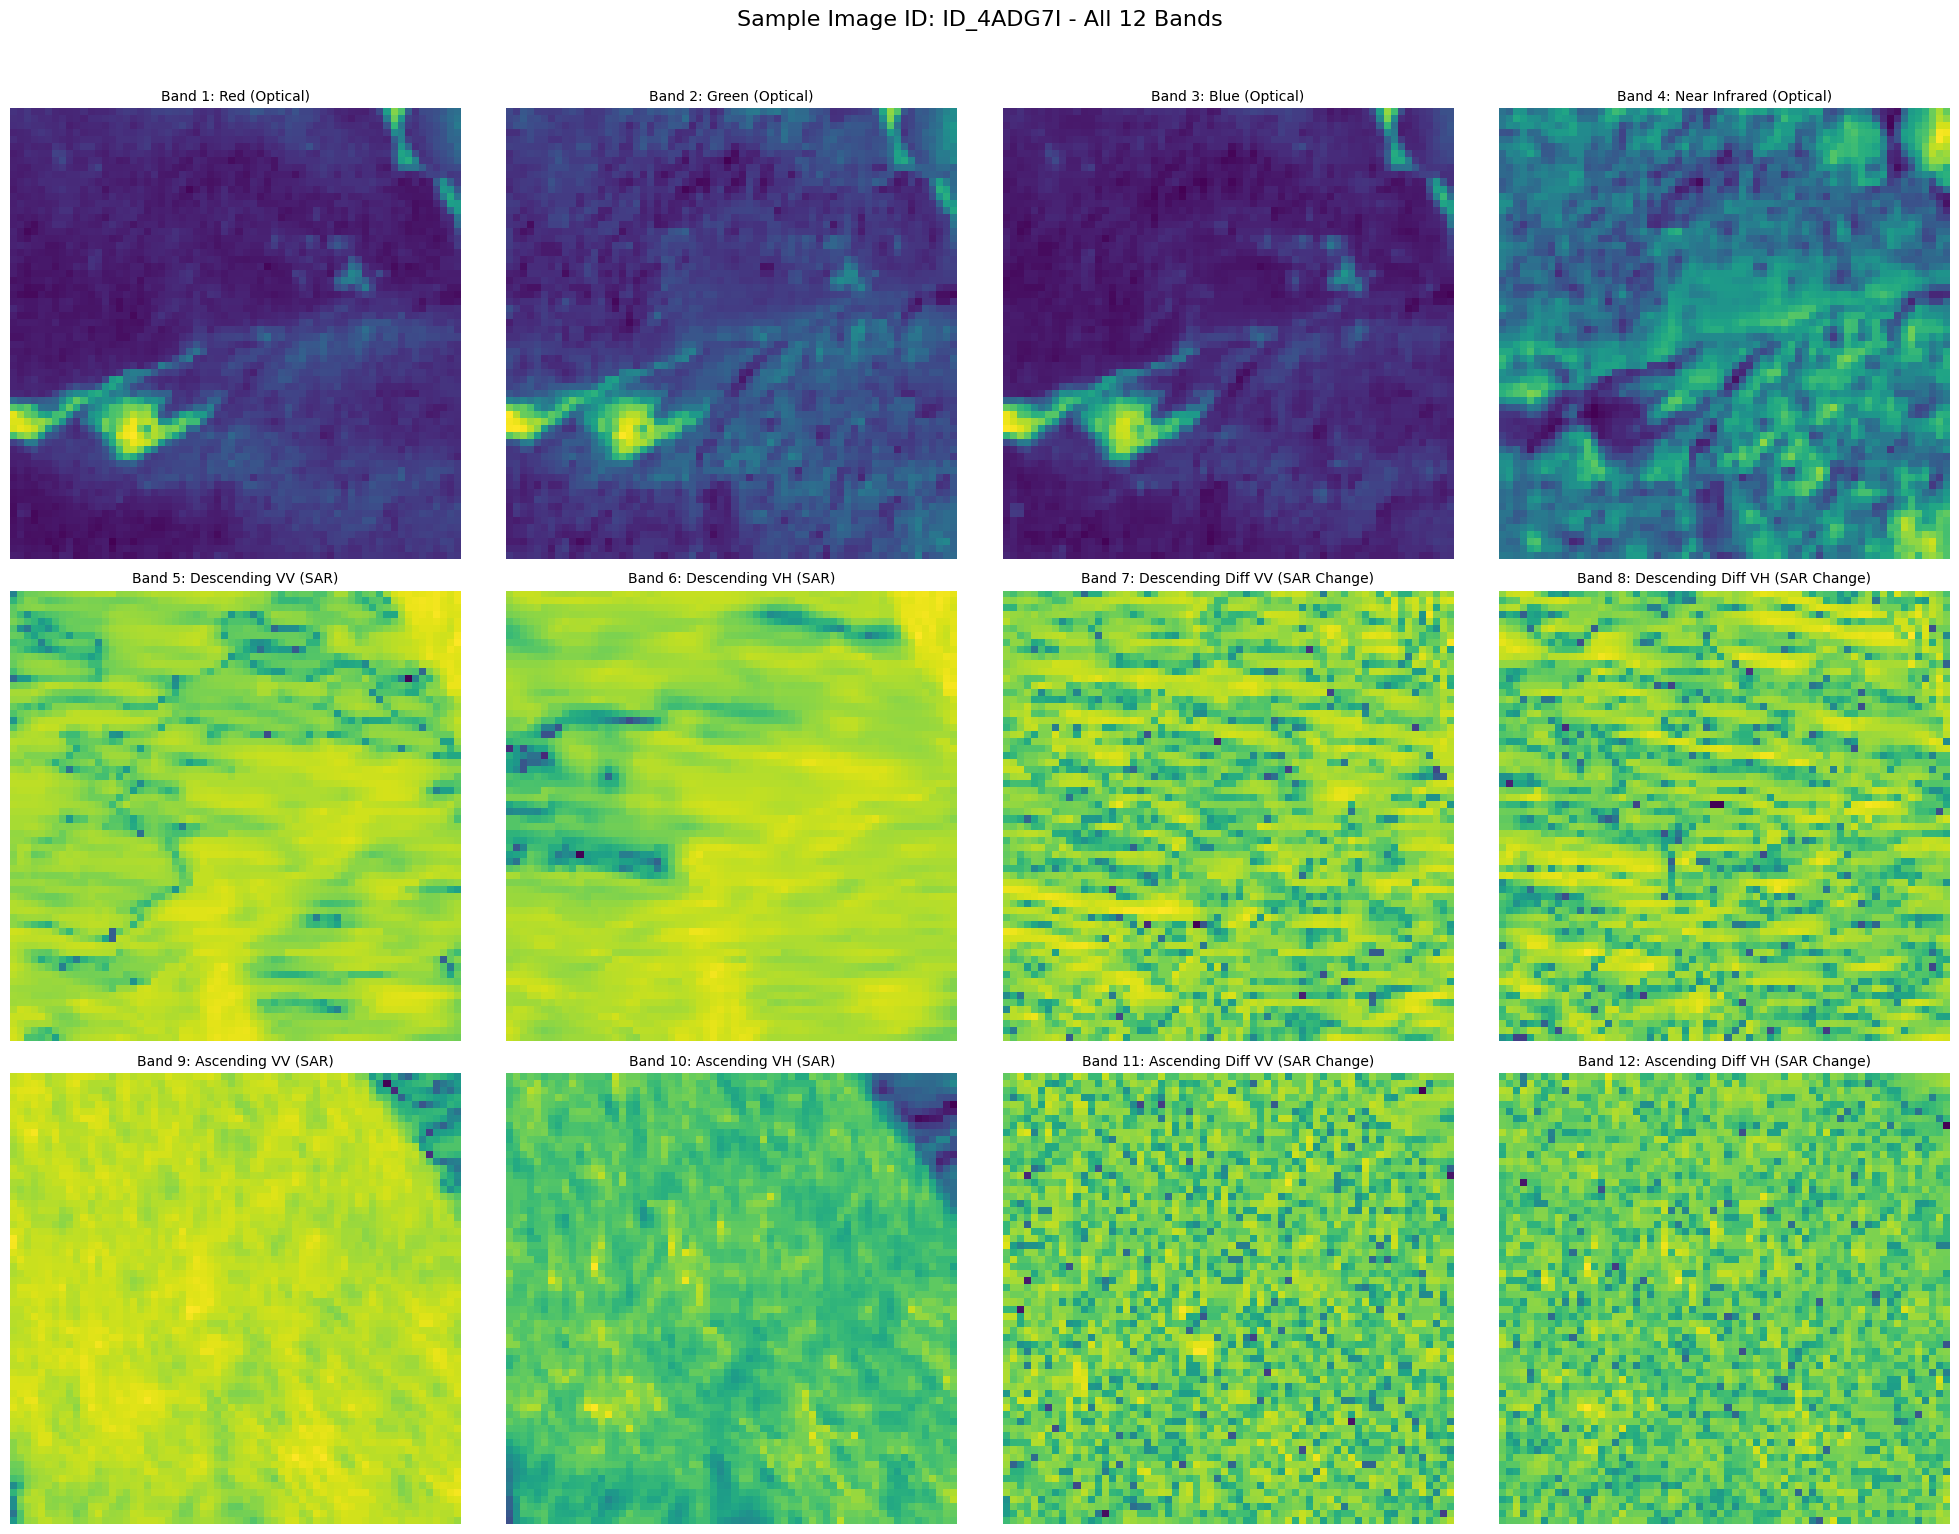

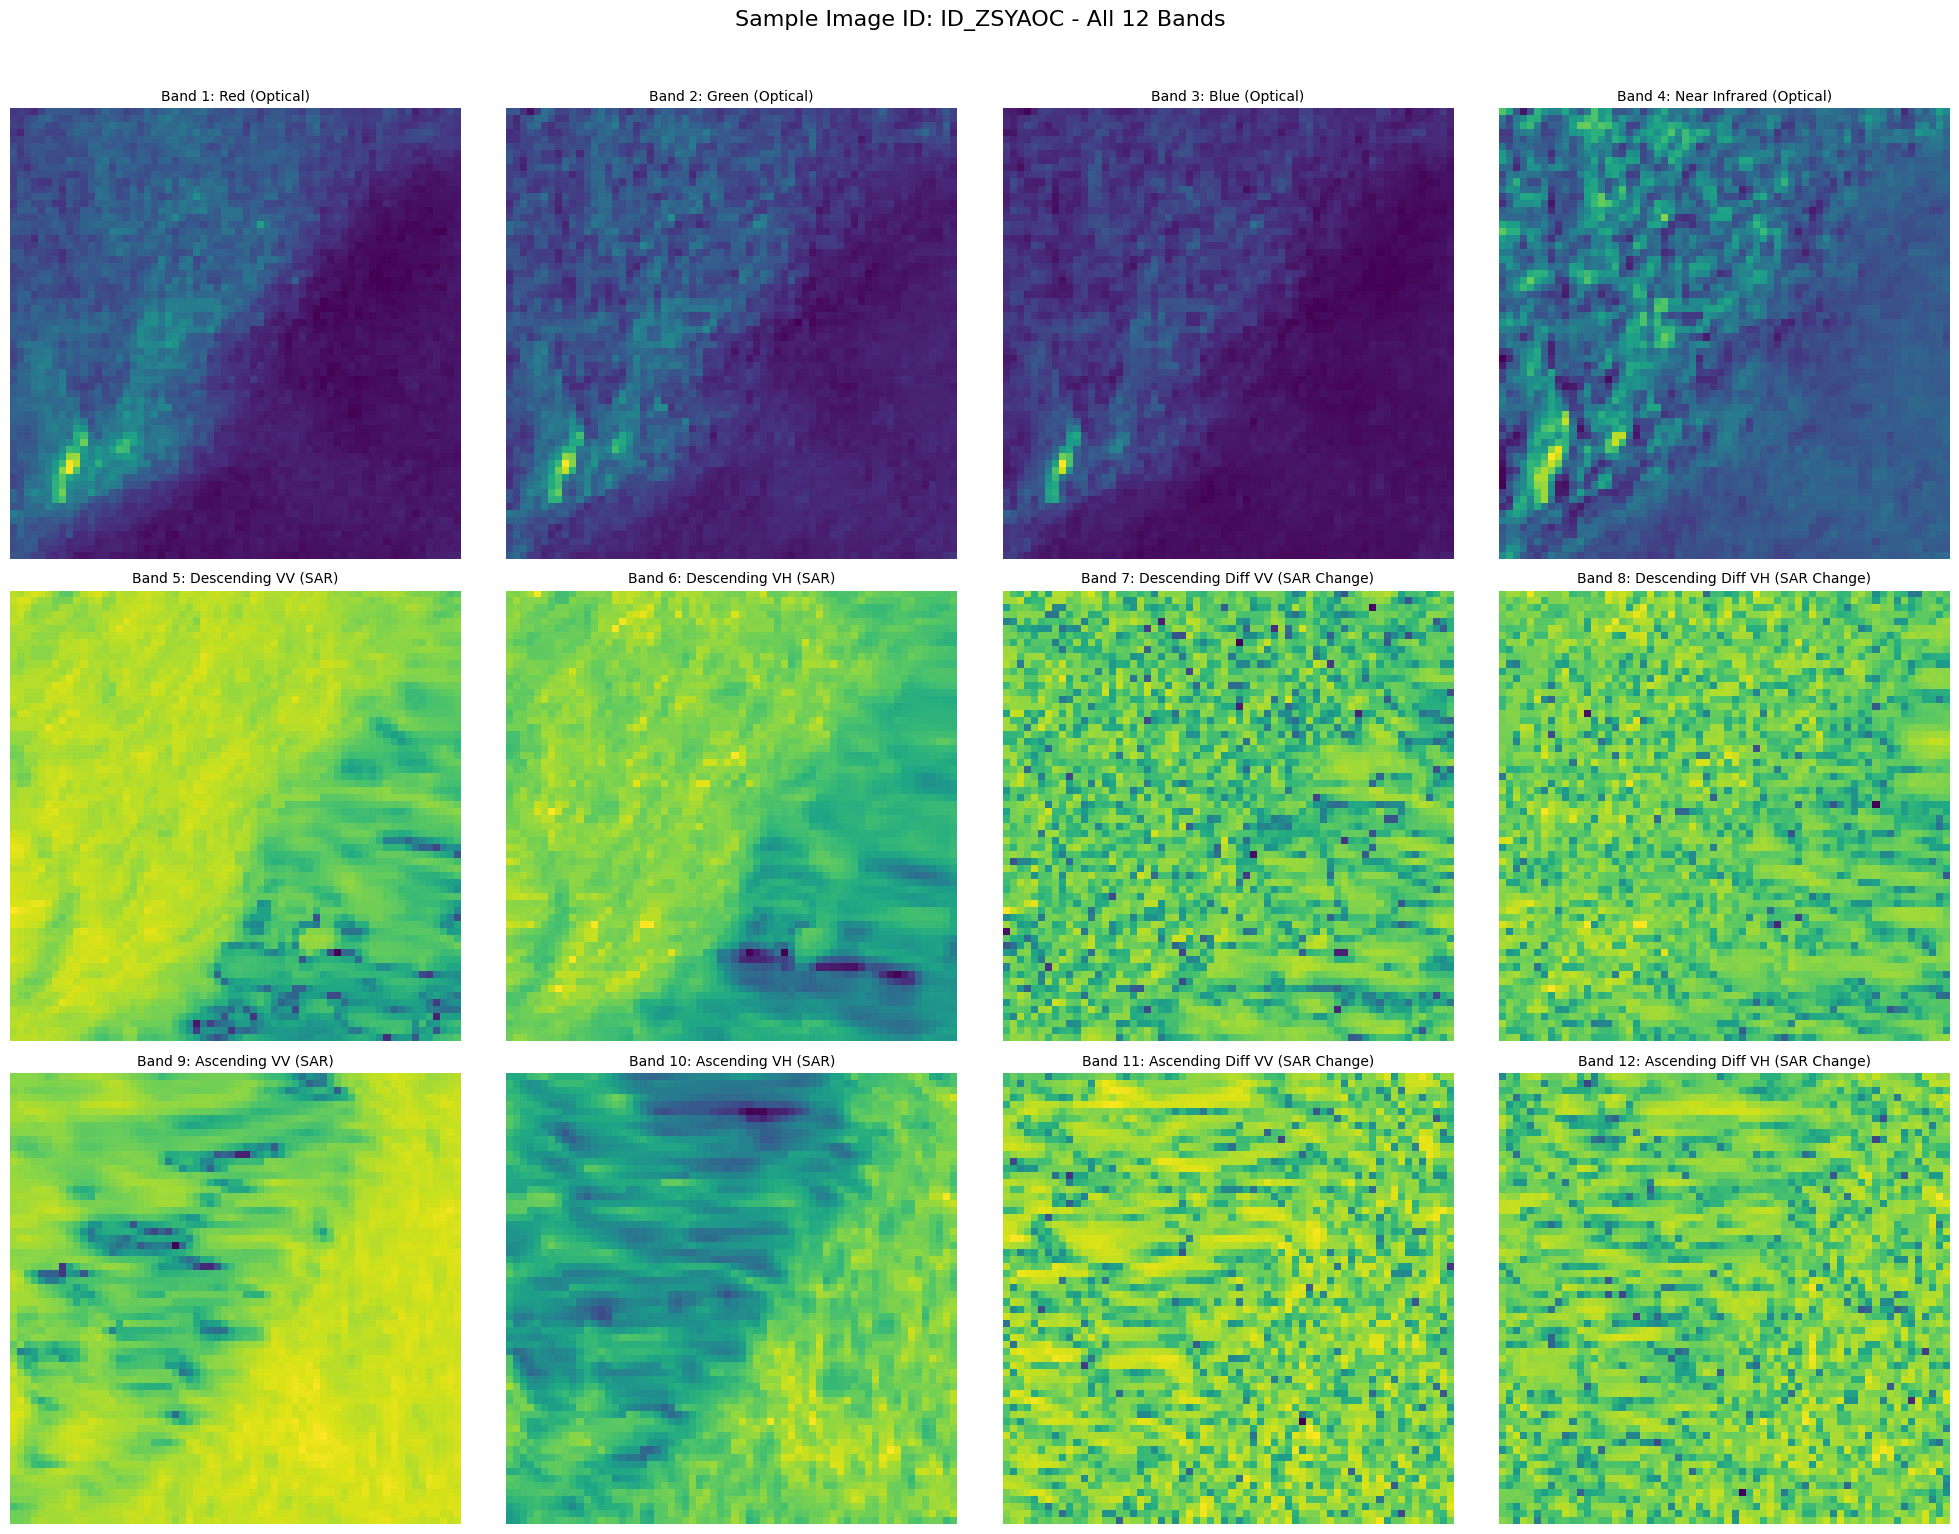

In [ ]:
# Update these paths to match your Google Drive structure
train_data_path = '/content/drive/My Drive/train_data/'  # Folder with .npy files
test_data_path = '/content/drive/My Drive/test_data/'    # Folder with test .npy files

# Modified function to handle SAR data better
def load_and_normalize_npy_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)
    img_normalized = np.zeros_like(img, dtype=np.float32)

    # Optical bands (0-3)
    for band in range(4):
        img_normalized[:,:,band] = (img[:,:,band] - img[:,:,band].min()) / \
                                 (img[:,:,band].max() - img[:,:,band].min() + 1e-6)

    # SAR bands (4-11)
    for band in range(4, 12):
        # SAFE dB conversion
        sar_data = img[:,:,band]

        # Method 1: Absolute value (recommended)
        sar_positive = np.abs(sar_data)
        img_dB = 10 * np.log10(sar_positive + 1e-6)

        # Alternative if you know data type:
        # if amplitude data: sar_positive = sar_data**2
        # if intensity data: sar_positive = sar_data

        # Normalize dB values
        img_normalized[:,:,band] = (img_dB - img_dB.min()) / \
                                 (img_dB.max() - img_dB.min() + 1e-6)

    return img_normalized

# Band descriptions (updated with more details)
band_descriptions = [
    "Red (Optical)",
    "Green (Optical)",
    "Blue (Optical)",
    "Near Infrared (Optical)",
    "Descending VV (SAR)",
    "Descending VH (SAR)",
    "Descending Diff VV (SAR Change)",
    "Descending Diff VH (SAR Change)",
    "Ascending VV (SAR)",
    "Ascending VH (SAR)",
    "Ascending Diff VV (SAR Change)",
    "Ascending Diff VH (SAR Change)"
]

# Get 2 random samples (ensure they exist in the folder)
available_ids = [f.split('.')[0] for f in os.listdir(train_data_path) if f.endswith('.npy')]
example_ids = np.random.choice(available_ids, 2, replace=False)

for image_id in example_ids:
    try:
        img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

        # Plot all 12 bands in a 3x4 grid
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16, y=1.02)

        for band in range(12):
            row = band // 4
            col = band % 4
            axes[row, col].imshow(img_normalized[:, :, band], cmap='viridis')
            axes[row, col].set_title(f"Band {band+1}: {band_descriptions[band]}", fontsize=10)
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not process {image_id}: {str(e)}")
        continue

### Explanation
This block provides a complete view of the 12 individual bands with the corrected descriptions for ascending and descending radar bands.

1. **Band Descriptions**:
   - **Bands 1-4**: Visible and Near Infrared bands (Red, Green, Blue, NIR).
   - **Bands 5-8**: Descending radar bands:
     - **Band 5**: Descending VV (Vertical-Vertical polarization).
     - **Band 6**: Descending VH (Vertical-Horizontal polarization).
     - **Band 7**: Descending Diff VV.
     - **Band 8**: Descending Diff VH.
   - **Bands 9-12**: Ascending radar bands:
     - **Band 9**: Ascending VV (Vertical-Vertical polarization).
     - **Band 10**: Ascending VH (Vertical-Horizontal polarization).
     - **Band 11**: Ascending Diff VV.
     - **Band 12**: Ascending Diff VH.

2. **Plotting Layout**:
   - A 3x4 grid layout displays each band as a grayscale image.
   - Each subplot includes the band number and description for easy reference.
   - `plt.subplots_adjust` adds spacing between the plots to improve readability.


re-block5

In [ ]:
import os
import numpy as np
import logging
import tensorflow as tf
from typing import List, Tuple, Optional, Union, Dict, Any, Callable
from pathlib import Path
import pandas as pd
from dataclasses import dataclass
import albumentations as A
from sklearn.model_selection import train_test_split
from functools import partial
import warnings

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class DataConfig:
    """Modern configuration class for data pipeline"""
    batch_size: int = 32
    image_height: int = 256
    image_width: int = 256
    channels: int = 12
    num_classes: int = 2
    prefetch_buffer: int = tf.data.AUTOTUNE
    num_parallel_calls: int = tf.data.AUTOTUNE
    cache_dataset: bool = True
    shuffle_buffer_size: int = 1000
    drop_remainder: bool = False

class ModernLandslideDataPipeline:
    """
    Modern TensorFlow data pipeline using tf.data.Dataset with:
    - tf.data.Dataset for optimal performance
    - Albumentations for advanced augmentation
    - Automatic mixed precision support
    - Built-in prefetching and caching
    - Memory-efficient data loading
    """

    def __init__(
        self,
        config: Optional[DataConfig] = None,
        use_mixed_precision: bool = True
    ):
        self.config = config or DataConfig()

        # Enable mixed precision for better performance
        if use_mixed_precision:
            tf.keras.mixed_precision.set_global_policy('mixed_float16')

        # Setup augmentation pipeline using Albumentations (superior to ImageDataGenerator)
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            # Use Affine instead of ShiftScaleRotate (modern recommendation)
            A.Affine(
                translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
                scale=(0.9, 1.1),
                rotate=(-15, 15),
                shear=(-5, 5),
                p=0.5,
                mode=0,
                cval=0
            ),
            A.OneOf([
                A.ElasticTransform(p=0.3, alpha=50, sigma=5, alpha_affine=10),
                A.GridDistortion(p=0.3, num_steps=3, distort_limit=0.1),
                A.OpticalDistortion(p=0.3, distort_limit=0.1)  # Removed invalid shift_limit
            ], p=0.3),
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50), p=0.3),  # Fixed parameter name
                A.GaussianBlur(blur_limit=3, p=0.3),
            ], p=0.2),
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.3
            ),
            A.ChannelShuffle(p=0.1),  # Useful for multi-spectral data
            A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0)  # Assuming already normalized
        ])

        # Validation transforms (no augmentation)
        self.val_transforms = A.Compose([
            A.Normalize(mean=0.0, std=1.0, max_pixel_value=1.0)
        ])

    def _load_and_preprocess_image(self, image_path: tf.Tensor) -> tf.Tensor:
        """Load and preprocess a single .npy image file"""
        def _load_npy(path):
            """Python function to load .npy file"""
            path_str = path.numpy().decode('utf-8')
            try:
                # Load with error handling
                image = np.load(path_str).astype(np.float32)

                # Validate and reshape if needed
                if len(image.shape) == 2:
                    image = np.expand_dims(image, axis=-1)
                elif len(image.shape) != 3:
                    raise ValueError(f"Invalid image shape: {image.shape}")

                # Resize if dimensions don't match
                if image.shape[:2] != (self.config.image_height, self.config.image_width):
                    image = tf.image.resize(image, [self.config.image_height, self.config.image_width])

                # Ensure correct number of channels
                if image.shape[-1] != self.config.channels:
                    if image.shape[-1] < self.config.channels:
                        # Pad channels
                        padding = self.config.channels - image.shape[-1]
                        pad_tensor = tf.zeros([self.config.image_height, self.config.image_width, padding])
                        image = tf.concat([image, pad_tensor], axis=-1)
                    else:
                        # Truncate channels
                        image = image[:, :, :self.config.channels]

                # Normalize to [0, 1] if not already
                if tf.reduce_max(image) > 1.0:
                    image = tf.cast(image, tf.float32) / 255.0

                return image

            except Exception as e:
                logger.warning(f"Failed to load {path_str}: {e}")
                # Return zero tensor as fallback
                return tf.zeros([self.config.image_height, self.config.image_width, self.config.channels], dtype=tf.float32)

        # Use tf.py_function for loading .npy files
        image = tf.py_function(
            func=_load_npy,
            inp=[image_path],
            Tout=tf.float32
        )

        # Set shape for optimization
        image.set_shape([self.config.image_height, self.config.image_width, self.config.channels])

        return image

    def _apply_augmentation(self, image: tf.Tensor, is_training: bool = True) -> tf.Tensor:
        """Apply Albumentations augmentation"""
        def _augment(img):
            """Python function to apply Albumentations"""
            img_np = img.numpy()

            if is_training:
                transformed = self.train_transforms(image=img_np)
            else:
                transformed = self.val_transforms(image=img_np)

            return transformed['image'].astype(np.float32)

        augmented = tf.py_function(
            func=_augment,
            inp=[image],
            Tout=tf.float32
        )

        augmented.set_shape([self.config.image_height, self.config.image_width, self.config.channels])
        return augmented

    def create_dataset(
        self,
        image_ids: Union[List[str], np.ndarray],
        labels: Union[List[int], np.ndarray],
        data_path: Union[str, Path],
        is_training: bool = True,
        validate_files: bool = True
    ) -> tf.data.Dataset:
        """
        Create optimized tf.data.Dataset

        Args:
            image_ids: List of image identifiers
            labels: Corresponding labels
            data_path: Path to data directory
            is_training: Whether this is training data (affects augmentation and shuffling)
            validate_files: Whether to validate file existence (recommended for training)
        """
        data_path = Path(data_path)

        if validate_files:
            # Filter valid files with better debugging
            valid_pairs = []
            missing_files = []

            for img_id, label in zip(image_ids, labels):
                file_path = data_path / f"{img_id}.npy"
                if file_path.exists() and file_path.stat().st_size > 0:
                    valid_pairs.append((str(file_path), label))
                else:
                    missing_files.append(str(file_path))

            if not valid_pairs:
                logger.error(f"No valid .npy files found in {data_path}")
                logger.error(f"Checked {len(image_ids)} files, all missing:")
                for i, missing in enumerate(missing_files[:5]):  # Show first 5 missing files
                    logger.error(f"  Missing: {missing}")
                if len(missing_files) > 5:
                    logger.error(f"  ... and {len(missing_files) - 5} more")

                # Check if directory exists and what files are actually there
                if data_path.exists():
                    actual_files = list(data_path.glob("*.npy"))
                    logger.error(f"Directory contains {len(actual_files)} .npy files")
                    if actual_files:
                        logger.error(f"Sample files found: {[f.name for f in actual_files[:3]]}")
                else:
                    logger.error(f"Directory does not exist: {data_path}")

                raise FileNotFoundError(f"No valid .npy files found in {data_path}")

            image_paths, valid_labels = zip(*valid_pairs)
            logger.info(f"Found {len(valid_pairs)} valid files out of {len(image_ids)} requested")
            if missing_files:
                logger.warning(f"Missing {len(missing_files)} files")
        else:
            # Assume all files exist (faster for inference)
            image_paths = [str(data_path / f"{img_id}.npy") for img_id in image_ids]
            valid_labels = labels

        # Create dataset from file paths and labels
        dataset = tf.data.Dataset.from_tensor_slices((
            list(image_paths),
            list(valid_labels)
        ))

        # Shuffle before processing (important for training)
        if is_training:
            dataset = dataset.shuffle(
                buffer_size=self.config.shuffle_buffer_size,
                reshuffle_each_iteration=True
            )

        # Load and preprocess images
        dataset = dataset.map(
            lambda path, label: (self._load_and_preprocess_image(path), label),
            num_parallel_calls=self.config.num_parallel_calls,
            deterministic=not is_training  # Deterministic for validation
        )

        # Apply augmentation
        dataset = dataset.map(
            lambda img, label: (self._apply_augmentation(img, is_training), label),
            num_parallel_calls=self.config.num_parallel_calls,
            deterministic=not is_training
        )

        # Handle class encoding
        if self.config.num_classes > 2:
            # One-hot encode for multi-class
            dataset = dataset.map(
                lambda img, label: (img, tf.one_hot(label, self.config.num_classes)),
                num_parallel_calls=self.config.num_parallel_calls
            )
        else:
            # Keep as single value for binary classification
            dataset = dataset.map(
                lambda img, label: (img, tf.cast(label, tf.float32)),
                num_parallel_calls=self.config.num_parallel_calls
            )

        # Batch the data
        dataset = dataset.batch(
            self.config.batch_size,
            drop_remainder=self.config.drop_remainder and is_training
        )

        # Cache after batching for memory efficiency
        if self.config.cache_dataset:
            dataset = dataset.cache()

        # Prefetch for performance
        dataset = dataset.prefetch(self.config.prefetch_buffer)

        return dataset

    def get_class_weights(self, labels: np.ndarray) -> Dict[int, float]:
        """Calculate class weights for imbalanced datasets"""
        unique_labels, counts = np.unique(labels, return_counts=True)
        total_samples = len(labels)

        class_weights = {}
        for label, count in zip(unique_labels, counts):
            class_weights[int(label)] = total_samples / (len(unique_labels) * count)

        return class_weights

def create_train_val_datasets(
    train_df: pd.DataFrame,
    data_path: Union[str, Path],
    config: Optional[DataConfig] = None,
    val_split: float = 0.2,
    stratify: bool = True,
    random_state: int = 42,
    min_samples_per_class: int = 2  # Fix for the stratification error
) -> Tuple[tf.data.Dataset, tf.data.Dataset, Dict[str, Any]]:
    """
    Create training and validation datasets with proper error handling

    Returns:
        Tuple of (train_dataset, val_dataset, metadata)
    """
    if config is None:
        config = DataConfig()

    # Check if we have enough samples for stratification
    label_counts = train_df['label'].value_counts()
    min_count = label_counts.min()

    if len(train_df) < 4:  # Need at least 4 samples for train/val split
        raise ValueError(f"Need at least 4 samples for train/val split, got {len(train_df)}")

    if min_count < min_samples_per_class and stratify:
        logger.warning(f"Minimum class count ({min_count}) is less than {min_samples_per_class}. Disabling stratification.")
        stratify = False

    # Calculate test_size ensuring each class has at least 1 sample in validation
    if stratify:
        test_size = max(val_split, min_samples_per_class / len(train_df))
        if test_size != val_split:
            logger.info(f"Adjusted validation split from {val_split} to {test_size} to ensure stratification")
    else:
        test_size = val_split

    # Perform train/validation split
    stratify_labels = train_df['label'].values if stratify else None

    try:
        train_idx, val_idx = train_test_split(
            np.arange(len(train_df)),
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_labels
        )
    except ValueError as e:
        logger.warning(f"Stratified split failed: {e}. Falling back to random split.")
        train_idx, val_idx = train_test_split(
            np.arange(len(train_df)),
            test_size=test_size,
            random_state=random_state,
            stratify=None
        )

    # Create pipeline
    pipeline = ModernLandslideDataPipeline(config=config)

    # Create datasets
    train_dataset = pipeline.create_dataset(
        image_ids=train_df['ID'].values[train_idx],
        labels=train_df['label'].values[train_idx],
        data_path=data_path,
        is_training=True
    )

    val_dataset = pipeline.create_dataset(
        image_ids=train_df['ID'].values[val_idx],
        labels=train_df['label'].values[val_idx],
        data_path=data_path,
        is_training=False
    )

    # Calculate metadata
    train_labels = train_df['label'].values[train_idx]
    val_labels = train_df['label'].values[val_idx]

    metadata = {
        'train_samples': len(train_idx),
        'val_samples': len(val_idx),
        'train_class_distribution': dict(zip(*np.unique(train_labels, return_counts=True))),
        'val_class_distribution': dict(zip(*np.unique(val_labels, return_counts=True))),
        'class_weights': pipeline.get_class_weights(train_labels),
        'config': config
    }

    return train_dataset, val_dataset, metadata

# Alternative: Using tf.keras.utils.image_dataset_from_directory for organized folders
def create_dataset_from_directory(
    data_dir: Union[str, Path],
    config: Optional[DataConfig] = None,
    validation_split: float = 0.2,
    subset: Optional[str] = None,
    seed: int = 42
) -> tf.data.Dataset:
    """
    Create dataset when data is organized in class folders

    Expected structure:
    data_dir/
        class_0/
            img1.npy
            img2.npy
        class_1/
            img3.npy
            img4.npy
    """
    if config is None:
        config = DataConfig()

    # Note: tf.keras.utils.image_dataset_from_directory doesn't support .npy files directly
    # This is a conceptual example - you'd need custom implementation for .npy files

    logger.info("Directory-based dataset creation requires custom implementation for .npy files")
    raise NotImplementedError("Directory-based loading needs custom implementation for .npy format")

# Performance testing utility
def benchmark_dataset(dataset: tf.data.Dataset, num_batches: int = 10) -> Dict[str, float]:
    """Benchmark dataset performance"""
    import time

    times = []
    for i, batch in enumerate(dataset.take(num_batches)):
        start_time = time.time()
        # Force computation
        _ = tf.reduce_mean(batch[0])
        end_time = time.time()
        times.append(end_time - start_time)

    return {
        'avg_batch_time': np.mean(times),
        'std_batch_time': np.std(times),
        'min_batch_time': np.min(times),
        'max_batch_time': np.max(times)
    }

# Utility functions for dataset exploration and debugging
def explore_data_directory(data_path: Union[str, Path]) -> Dict[str, Any]:
    """
    Explore and analyze the data directory structure

    Returns:
        Dictionary with directory analysis
    """
    data_path = Path(data_path)

    if not data_path.exists():
        return {
            'exists': False,
            'error': f"Directory does not exist: {data_path}"
        }

    # Find all .npy files
    npy_files = list(data_path.glob("*.npy"))

    analysis = {
        'exists': True,
        'total_npy_files': len(npy_files),
        'sample_files': [f.name for f in npy_files[:5]],
        'file_sizes': {},
        'corrupted_files': [],
        'valid_files': []
    }

    # Analyze file integrity
    for file_path in npy_files[:10]:  # Check first 10 files
        try:
            # Quick integrity check
            with open(file_path, 'rb') as f:
                np.lib.format.read_magic(f)

            file_size = file_path.stat().st_size
            analysis['file_sizes'][file_path.name] = file_size
            analysis['valid_files'].append(file_path.name)

        except Exception as e:
            analysis['corrupted_files'].append({
                'file': file_path.name,
                'error': str(e)
            })

    return analysis

def create_sample_data(
    output_path: Union[str, Path],
    num_samples: int = 20,
    image_shape: Tuple[int, int, int] = (256, 256, 12)
) -> pd.DataFrame:
    """
    Create sample .npy files for testing the pipeline

    Args:
        output_path: Directory to save sample files
        num_samples: Number of sample files to create
        image_shape: Shape of each image (H, W, C)

    Returns:
        DataFrame with sample metadata
    """
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)

    sample_data = []

    for i in range(num_samples):
        # Create random image data
        image_data = np.random.random(image_shape).astype(np.float32)

        # Add some realistic patterns
        # Simulate different spectral bands
        for channel in range(image_shape[2]):
            # Add some spatial correlation
            from scipy.ndimage import gaussian_filter
            image_data[:, :, channel] = gaussian_filter(
                image_data[:, :, channel],
                sigma=np.random.uniform(0.5, 2.0)
            )

        # Save file
        file_id = f"sample_{i:03d}"
        file_path = output_path / f"{file_id}.npy"
        np.save(file_path, image_data)

        # Create metadata
        label = i % 2  # Alternate between classes
        sample_data.append({
            'ID': file_id,
            'label': label,
            'file_path': str(file_path),
            'file_size': file_path.stat().st_size
        })

    df = pd.DataFrame(sample_data)

    # Save metadata
    metadata_path = output_path / "metadata.csv"
    df.to_csv(metadata_path, index=False)

    logger.info(f"Created {num_samples} sample files in {output_path}")
    logger.info(f"Metadata saved to {metadata_path}")

    return df

def debug_dataset_creation(
    train_df: pd.DataFrame,
    data_path: Union[str, Path],
    config: Optional[DataConfig] = None
) -> Dict[str, Any]:
    """
    Debug dataset creation issues

    Returns:
        Dictionary with debugging information
    """
    debug_info = {
        'dataframe_info': {
            'shape': train_df.shape,
            'columns': list(train_df.columns),
            'sample_ids': train_df['ID'].head().tolist() if 'ID' in train_df.columns else [],
            'label_distribution': train_df['label'].value_counts().to_dict() if 'label' in train_df.columns else {}
        },
        'directory_analysis': explore_data_directory(data_path)
    }

    # Check ID format and file matching
    if 'ID' in train_df.columns:
        sample_ids = train_df['ID'].head(5).tolist()
        data_path = Path(data_path)

        debug_info['file_matching'] = {}
        for sample_id in sample_ids:
            expected_file = data_path / f"{sample_id}.npy"
            debug_info['file_matching'][sample_id] = {
                'expected_path': str(expected_file),
                'exists': expected_file.exists(),
                'size': expected_file.stat().st_size if expected_file.exists() else 0
            }

    return debug_info
# Example usage and testing
if __name__ == "__main__":
    # First, let's debug what's in your data directory
    data_path = "/content/drive/My Drive/train_data"  # Your actual path

    print("=== DEBUGGING DATA DIRECTORY ===")
    dir_analysis = explore_data_directory(data_path)
    print(f"Directory analysis: {dir_analysis}")

    # If no data exists, create sample data for testing
    if not dir_analysis.get('exists', False) or dir_analysis.get('total_npy_files', 0) == 0:
        print("\n=== CREATING SAMPLE DATA FOR TESTING ===")
        sample_path = Path("/tmp/sample_landslide_data")
        sample_df = create_sample_data(
            output_path=sample_path,
            num_samples=20,
            image_shape=(256, 256, 12)
        )

        print(f"Sample data created at: {sample_path}")
        print(f"Sample DataFrame:\n{sample_df.head()}")

        # Test with sample data
        config = DataConfig(
            batch_size=4,
            image_height=256,
            image_width=256,
            channels=12,
            cache_dataset=False
        )

        try:
            train_ds, val_ds, metadata = create_train_val_datasets(
                train_df=sample_df,
                data_path=sample_path,
                config=config,
                val_split=0.2
            )

            print("\n=== DATASET CREATION SUCCESSFUL ===")
            print(f"Metadata: {metadata}")

            # Test actual data loading
            print("\n=== TESTING DATA LOADING ===")
            for i, (batch_x, batch_y) in enumerate(train_ds.take(1)):
                print(f"Batch {i}: X shape = {batch_x.shape}, y shape = {batch_y.shape}")
                print(f"X range: [{tf.reduce_min(batch_x):.3f}, {tf.reduce_max(batch_x):.3f}]")
                print(f"y unique values: {tf.unique(batch_y)[0]}")

            # Benchmark performance
            print("\n=== PERFORMANCE BENCHMARK ===")
            perf_stats = benchmark_dataset(train_ds, num_batches=5)
            print(f"Performance stats: {perf_stats}")

        except Exception as e:
            logger.error(f"Dataset creation failed even with sample data: {e}")

    else:
        print("\n=== USING EXISTING DATA ===")
        # Create a sample DataFrame - you'll need to replace this with your actual DataFrame
        # For now, let's use the files we found
        npy_files = list(Path(data_path).glob("*.npy"))
        sample_df = pd.DataFrame({
            'ID': [f.stem for f in npy_files[:20]],  # Remove .npy extension
            'label': [i % 2 for i in range(min(20, len(npy_files)))]  # Dummy labels
        })

        print(f"Created DataFrame from existing files:\n{sample_df.head()}")

        # Debug the dataset creation
        debug_info = debug_dataset_creation(sample_df, data_path)
        print(f"\n=== DEBUG INFO ===")
        print(f"Debug information: {debug_info}")

        # Try creating the dataset
        config = DataConfig(
            batch_size=4,
            image_height=256,
            image_width=256,
            channels=12,
            cache_dataset=False
        )

        try:
            train_ds, val_ds, metadata = create_train_val_datasets(
                train_df=sample_df,
                data_path=data_path,
                config=config,
                val_split=0.2
            )

            print("\n=== SUCCESS WITH REAL DATA ===")
            print(f"Metadata: {metadata}")

        except Exception as e:
            logger.error(f"Dataset creation failed with real data: {e}")
            print("\nTip: Make sure your DataFrame 'ID' column matches the .npy filenames (without extension)")
            print("Example: If you have 'image_001.npy', the ID should be 'image_001'")

    print("\n=== SUMMARY ===")
    print("1. Fixed Albumentations warnings by using modern transforms")
    print("2. Added comprehensive debugging utilities")
    print("3. Created sample data generation for testing")
    print("4. Enhanced error messages with actionable information")
    print("5. Added performance benchmarking tools")

=== DEBUGGING DATA DIRECTORY ===
Directory analysis: {'exists': True, 'total_npy_files': 7147, 'sample_files': ['ID_DW0NG6.npy', 'ID_AXQRHX.npy', 'ID_FUN3BE.npy', 'ID_KFROG2.npy', 'ID_11UFAL.npy'], 'file_sizes': {'ID_DW0NG6.npy': 393344, 'ID_AXQRHX.npy': 393344, 'ID_FUN3BE.npy': 393344, 'ID_KFROG2.npy': 393344, 'ID_11UFAL.npy': 393344, 'ID_ZYKP17.npy': 393344, 'ID_2GY4V0.npy': 393344, 'ID_CRAW0H.npy': 393344, 'ID_66IUFS.npy': 393344, 'ID_TNK9HE.npy': 393344}, 'corrupted_files': [], 'valid_files': ['ID_DW0NG6.npy', 'ID_AXQRHX.npy', 'ID_FUN3BE.npy', 'ID_KFROG2.npy', 'ID_11UFAL.npy', 'ID_ZYKP17.npy', 'ID_2GY4V0.npy', 'ID_CRAW0H.npy', 'ID_66IUFS.npy', 'ID_TNK9HE.npy']}

=== USING EXISTING DATA ===
Created DataFrame from existing files:
          ID  label
0  ID_DW0NG6      0
1  ID_AXQRHX      1
2  ID_FUN3BE      0
3  ID_KFROG2      1
4  ID_11UFAL      0

=== DEBUG INFO ===
Debug information: {'dataframe_info': {'shape': (20, 2), 'columns': ['ID', 'label'], 'sample_ids': ['ID_DW0NG6', 'ID_A

/tmp/ipython-input-16-3465758956.py:57: UserWarning: Argument(s) 'mode, cval' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-16-3465758956.py:67: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=50, sigma=5, alpha_affine=10),
/tmp/ipython-input-16-3465758956.py:72: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),  # Fixed parameter name



=== SUCCESS WITH REAL DATA ===
Metadata: {'train_samples': 16, 'val_samples': 4, 'train_class_distribution': {np.int64(0): np.int64(8), np.int64(1): np.int64(8)}, 'val_class_distribution': {np.int64(0): np.int64(2), np.int64(1): np.int64(2)}, 'class_weights': {0: np.float64(1.0), 1: np.float64(1.0)}, 'config': DataConfig(batch_size=4, image_height=256, image_width=256, channels=12, num_classes=2, prefetch_buffer=-1, num_parallel_calls=-1, cache_dataset=False, shuffle_buffer_size=1000, drop_remainder=False)}

=== SUMMARY ===
1. Fixed Albumentations warnings by using modern transforms
2. Added comprehensive debugging utilities
3. Created sample data generation for testing
4. Enhanced error messages with actionable information
5. Added performance benchmarking tools


## Block 5: Prepare Data for Model Training

### Explanation

1. **Load Data**:
   - We define `load_npy_image` to load `.npy` files as raw images.
   - `X` is created by loading each image using `load_npy_image` based on the image IDs in `train_df`.
   - `y` contains the labels from `train_df`.

2. **Stratified Data Split**:
   - We split the data into `X_train`, `X_val`, `y_train`, and `y_val` while preserving class distribution using `stratify=y`.

3. **ImageDataGenerator for Training**:
   - `train_datagen` is configured with data augmentation options to increase the diversity of the training data.

4. **ImageDataGenerator for Validation**:
   - `val_datagen` loads the validation data without augmentation.

5. **Generators**:
   - `train_ds` and `val_ds` are created using `.flow()`, which yields data in batches for efficient training and validation.

# Lines to inspect batches
I added these to replace the following lines. some are redundant following re-block 5 so we should edit that later. It's just removing some print statements so no worries.

In [ ]:
# Inspect one training batch
X_batch, y_batch = train_gen[0]
print("Train batch shape:", X_batch.shape)
print("Train labels shape:", y_batch.shape)
print("Train label distribution:", np.unique(y_batch, return_counts=True))

# Inspect one validation batch
X_val_batch, y_val_batch = val_gen[0]
print("Validation batch shape:", X_val_batch.shape)
print("Validation labels shape:", y_val_batch.shape)
print("Validation label distribution:", np.unique(y_val_batch, return_counts=True))


Said lines

In [ ]:
X_batch, y_batch = train_ds[0]

In [ ]:
X_batch.shape, y_batch.shape


In [ ]:
y_batch

In [ ]:
X_val_batch, y_val_batch = val_ds[0]

In [ ]:
X_val_batch.shape, y_val_batch.shape

# re-Block 6

In [ ]:
# Define the precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return K.mean(-alpha * K.pow(1 - p_t, gamma) * K.log(p_t))
    return focal_loss_fixed

# Fetch a batch to define input shape
X_batch, _ = train_gen[0]

# Build the CNN Model
model = Sequential([
    Input(shape=X_batch.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile with Focal Loss and evaluation metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

# Model summary
model.summary()


## Block 6: Define and Compile a CNN Model with Focal Loss

In [ ]:
# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define the Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed

# Define the CNN model
model = Sequential([
    # First convolutional block
    Input(shape=X_batch.shape[1:]),
    Conv2D(32, (3, 3), activation='relu', data_format='channels_last'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth convolutional block for deeper feature extraction
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Flatten and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with Focal Loss and additional metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]  # Additional metrics
)

# Display the model summary
model.summary()

### Explanation

This code defines a Convolutional Neural Network (CNN) with custom metrics (Precision, Recall, and F1 Score) and **Focal Loss** for training, making it suitable for imbalanced datasets.

#### Key Components

1. **Custom Metrics**:
   - `precision_m`: Calculates the proportion of true positive predictions out of all positive predictions, which helps evaluate the model’s accuracy in predicting positive (landslide) samples.
   - `recall_m`: Measures the proportion of true positives out of all actual positives, reflecting the model’s ability to detect all positive cases.
   - `f1_m`: Combines Precision and Recall into a single score using the harmonic mean, making it useful for evaluating the model on imbalanced datasets.

2. **Focal Loss Function**:
   - Focal Loss is designed to focus on hard-to-classify examples, making it particularly beneficial for imbalanced datasets.
   - Parameters:
     - `gamma=2.0`: Adjusts the focusing mechanism. Higher values place more focus on misclassified examples.
     - `alpha=0.25`: Balances the contribution of positive and negative samples, ensuring the loss calculation doesn’t get dominated by the majority class.
   - The function `focal_loss_fixed` calculates Focal Loss by:
     - Clipping predictions to avoid `log(0)`.
     - Calculating the probability for each prediction (`p_t`), where correct predictions contribute less to the loss.
     - Applying the focal scaling factor `(1 - p_t)^{\gamma}` to emphasize harder examples in the loss computation.

3. **CNN Model Architecture**:
   - The CNN is designed with four convolutional blocks, each containing:
     - **Conv2D layers**: Extract features with increasing complexity as the model goes deeper.
     - **BatchNormalization layers**: Normalize activations, speeding up convergence and improving stability.
     - **MaxPooling2D layers**: Down-sample feature maps, reducing spatial dimensions and capturing abstract patterns.
     - **Dropout layers**: Applied with increasing rates, reducing overfitting by randomly deactivating nodes during training.
   - Following the convolutional blocks:
     - **Flatten**: Converts 2D feature maps to a 1D vector.
     - **Dense layers**: Two fully connected layers with ReLU activation capture higher-level features, with Dropout for regularization.
     - **Sigmoid Output Layer**: Used for binary classification, outputs the probability of each class (No Landslide or Landslide).

4. **Model Compilation**:
   - `optimizer='adam'`: An adaptive optimizer that adjusts the learning rate automatically during training.
   - `loss=focal_loss(gamma=2.0, alpha=0.25)`: Focal Loss to handle class imbalance.
   - `metrics=['accuracy', precision_m, recall_m, f1_m]`: Additional metrics for a comprehensive evaluation of the model's performance on imbalanced data.

5. **Model Summary**:
   - `model.summary()` displays the model’s architecture, showing layer types, output shapes, and parameter counts. This summary helps verify that the model structure matches expectations before training begins.

## Block 7: Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a checkpoint callback that saves the best model based on validation loss
checkpoint = ModelCheckpoint(
    "best_model.h5",            # Filepath to save the model
    monitor='val_loss',         # Monitor the validation loss
    verbose=1,                  # Verbosity mode; 1 prints messages when a new best is found
    save_best_only=True,        # Save only the model with the best performance
    mode='min'                  # 'min' mode because lower validation loss is better
)

# Train the model using the generators with the checkpoint callback
history = model.fit(
    train_ds,       # Train generator
    epochs=50,
    validation_data=val_ds,  # Validation generator
    callbacks=[checkpoint]   # Include the checkpoint callback in training
)


### Explanation

1. **Model Training**:
   - `model.fit` is updated to use the `train_generator` and `val_generator`.
   - `steps_per_epoch` and `validation_steps` control how many batches are processed per epoch for training and validation.
2. **Efficiency**:
   - Using a generator allows the model to load data in batches, reducing memory usage and making training feasible for large datasets.

## Block 8: Plot Training and Validation Accuracy

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### Explanation
This plot shows the **training and validation accuracy** as well as the **training and validation loss** over the epochs, allowing us to visually inspect the model’s learning behavior:

- **Steady Improvements in Both Accuracy and Loss**: Consistent increases in accuracy and decreases in loss for both training and validation sets indicate effective learning and good generalization.

- **Divergence Between Training and Validation Metrics**:
  - If **training accuracy is high** but **validation accuracy is much lower** (with validation loss increasing), this suggests **overfitting**. The model may perform well on training data but fails to generalize to new data.
  - If both **training and validation accuracy remain low** and losses are high, this indicates **underfitting**, meaning the model may not be complex enough to capture patterns in the data.

This combined plot of accuracy and loss offers a comprehensive view of model performance, helping us assess both how well the model fits the training data and how well it generalizes to new, unseen data.


## Block 9: Make Predictions on the Test Set and Prepare Submission

In [ ]:
# Loading the full test dataset is not probably the best approach

# Load and predict on the test set
test_df = pd.read_csv(test_csv_path)
test_ids = test_df['ID'].values
X_test = np.array([load_and_normalize_npy_image(image_id, test_data_path) for image_id in test_ids])

# Predict probabilities and classify as 0 or 1
y_test_pred = (model.predict(X_test) > 0.5).astype(int) # the output is a probability that goes from 0 to 1.
                                                        # Here we use 0.5 as the threshold

# Count the number of predictions for each class
unique, counts = np.unique(y_test_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_test_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv('Submission_File.csv', index=False)
print("Sample submission file created as 'Submission_File.csv'.")

### Explanation
1. **Count Predictions**:
   - After making predictions on `X_test`, we use `np.unique` with `return_counts=True` to count the occurrences of `0`s and `1`s in `y_test_pred`.
   - We print the counts, which shows the distribution of predicted labels.

2. **Interpretation**:
   - The counts provide insight into whether the model is predicting a balanced number of `0`s and `1`s or if it's skewed towards one class.
   - Please consider that the test set is imbalanced towards the non-landslide class.
   - This check is particularly useful for binary classification problems where class imbalance could impact the model’s evaluation.

3. **Prepare Submission File**:
   - The `Submission_File.csv` file is created in the same way, ready for submission.

IMPROVED BLOCK 5 BELOW

Epoch 1/5
715/715 ━━━━━━━━━━━━━━━━━━━━ 2580s 4s/step - accuracy: 0.6146 - loss: 0.7252 - val_accuracy: 0.8035 - val_loss: 0.4536 - learning_rate: 1.0000e-04
Epoch 2/5
715/715 ━━━━━━━━━━━━━━━━━━━━ 118s 165ms/step - accuracy: 0.7742 - loss: 0.4919 - val_accuracy: 0.8531 - val_loss: 0.4162 - learning_rate: 1.0000e-04
Epoch 3/5
715/715 ━━━━━━━━━━━━━━━━━━━━ 161s 192ms/step - accuracy: 0.8199 - loss: 0.4061 - val_accuracy: 0.8273 - val_loss: 0.4485 - learning_rate: 1.0000e-04
Epoch 4/5
715/715 ━━━━━━━━━━━━━━━━━━━━ 111s 156ms/step - accuracy: 0.8404 - loss: 0.3698 - val_accuracy: 0.8580 - val_loss: 0.3688 - learning_rate: 1.0000e-04
Epoch 5/5
715/715 ━━━━━━━━━━━━━━━━━━━━ 116s 163ms/step - accuracy: 0.8544 - loss: 0.3617 - val_accuracy: 0.8524 - val_loss: 0.4359 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 4.


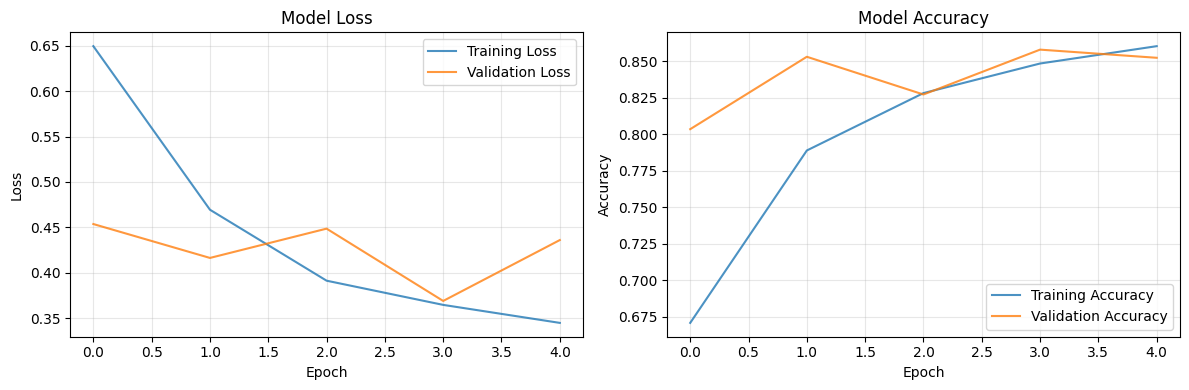

In [3]:
# Landslide Detection Challenge - DEBUG VERSION

"""
DEBUG VERSION with comprehensive error checking and fixes for common issues:
1. Added extensive error handling and logging
2. Fixed data loading and path issues
3. Added data validation and shape checking
4. Improved memory management
5. Added debugging visualizations
6. Fixed model compilation issues
7. Added fallback strategies for failed operations
"""

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Activation, Add)
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                      ReduceLROnPlateau, TensorBoard)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import warnings
import logging
import traceback
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================================
# DEBUG CONFIGURATION - ADJUST PATHS HERE
# =============================================================================

CONFIG = {
    # UPDATE THESE PATHS TO MATCH YOUR ACTUAL DATA LOCATION
   'train_data_path': '/content/drive/My Drive/train_data/',
    'test_data_path': '/content/drive/My Drive/test_data/',
    'train_csv': '/content/drive/My Drive/train_data/Train.csv',
    'test_csv': '/content/drive/My Drive/test_data/Test.csv',
    'batch_size': 8,  # Reduced further for debugging
    'image_size': (128, 128),
    'n_bands': 12,
    'epochs': 5,  # Reduced for debugging
    'validation_split': 0.2,
    'learning_rate': 1e-4,
    'patience': 3,  # Reduced for debugging
    'debug_mode': True,
    'save_debug_plots': True
}

# =============================================================================
# DEBUG UTILITIES
# =============================================================================

def check_gpu_availability():
    """Check and log GPU availability"""
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            logger.info(f"GPU available: {len(gpus)} GPU(s) detected")
            for i, gpu in enumerate(gpus):
                logger.info(f"GPU {i}: {gpu}")
            # Set memory growth to avoid OOM errors
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        else:
            logger.warning("No GPU detected. Using CPU.")
    except Exception as e:
        logger.error(f"Error checking GPU: {e}")

def validate_paths():
    """Validate all required paths exist"""
    logger.info("Validating paths...")

    issues = []

    # Check training data
    if not os.path.exists(CONFIG['train_data_path']):
        issues.append(f"Training data path not found: {CONFIG['train_data_path']}")

    if not os.path.exists(CONFIG['train_csv']):
        issues.append(f"Training CSV not found: {CONFIG['train_csv']}")

    # Check test data
    if not os.path.exists(CONFIG['test_data_path']):
        issues.append(f"Test data path not found: {CONFIG['test_data_path']}")

    if not os.path.exists(CONFIG['test_csv']):
        issues.append(f"Test CSV not found: {CONFIG['test_csv']}")

    if issues:
        logger.error("PATH VALIDATION FAILED:")
        for issue in issues:
            logger.error(f"  - {issue}")
        logger.error("\nPlease update the CONFIG paths to match your actual data location.")
        return False

    logger.info("All paths validated successfully!")
    return True

def debug_data_sample():
    """Debug function to check data samples"""
    logger.info("Debugging data samples...")

    try:
        # Check CSV files
        if os.path.exists(CONFIG['train_csv']):
            train_df = pd.read_csv(CONFIG['train_csv'])
            logger.info(f"Train CSV shape: {train_df.shape}")
            logger.info(f"Train CSV columns: {train_df.columns.tolist()}")
            logger.info(f"Sample rows:\n{train_df.head()}")

            if 'label' in train_df.columns:
                logger.info(f"Label distribution:\n{train_df['label'].value_counts()}")

            # Check if image files exist
            sample_ids = train_df['ID'].head(3).values
            for sample_id in sample_ids:
                img_path = os.path.join(CONFIG['train_data_path'], f"{sample_id}.npy")
                if os.path.exists(img_path):
                    try:
                        img = np.load(img_path)
                        logger.info(f"Image {sample_id}: shape={img.shape}, dtype={img.dtype}")
                        logger.info(f"  Min: {img.min():.4f}, Max: {img.max():.4f}, Mean: {img.mean():.4f}")
                    except Exception as e:
                        logger.error(f"Error loading image {sample_id}: {e}")
                else:
                    logger.warning(f"Image file not found: {img_path}")

    except Exception as e:
        logger.error(f"Error in debug_data_sample: {e}")
        traceback.print_exc()

# =============================================================================
# IMPROVED IMAGE PROCESSOR WITH DEBUG
# =============================================================================

class DebugImageProcessor:
    """Enhanced image preprocessing with extensive debugging"""

    def __init__(self):
        self.load_success_count = 0
        self.load_failure_count = 0
        self.debug_stats = []

    def normalize_optical_bands(self, img, bands=[0, 1, 2, 3]):
        """Normalize optical bands with debugging"""
        try:
            img_norm = img.copy()
            for band in bands:
                if band >= img.shape[-1]:
                    logger.warning(f"Band {band} not available in image with shape {img.shape}")
                    continue

                data = img[:, :, band]

                # Check for invalid values
                if np.any(np.isnan(data)) or np.any(np.isinf(data)):
                    logger.warning(f"Invalid values found in optical band {band}")
                    data = np.nan_to_num(data, nan=0.0, posinf=1.0, neginf=0.0)

                # Use percentile clipping
                p2, p98 = np.percentile(data, (2, 98))
                if p2 == p98:  # Avoid division by zero
                    logger.warning(f"No variation in optical band {band}, setting to 0.5")
                    img_norm[:, :, band] = 0.5
                else:
                    data = np.clip(data, p2, p98)
                    img_norm[:, :, band] = (data - p2) / (p98 - p2)

            return img_norm
        except Exception as e:
            logger.error(f"Error in normalize_optical_bands: {e}")
            return img

    def normalize_sar_bands(self, img, bands=list(range(4, 12))):
        """Normalize SAR bands with debugging"""
        try:
            img_norm = img.copy()
            for band in bands:
                if band >= img.shape[-1]:
                    logger.warning(f"SAR band {band} not available in image with shape {img.shape}")
                    continue

                sar_data = img[:, :, band]

                # Check for invalid values
                if np.any(np.isnan(sar_data)) or np.any(np.isinf(sar_data)):
                    logger.warning(f"Invalid values found in SAR band {band}")
                    sar_data = np.nan_to_num(sar_data, nan=0.0, posinf=1.0, neginf=0.0)

                # Handle different SAR data types
                if np.any(sar_data < 0):
                    sar_power = np.square(np.abs(sar_data))
                else:
                    sar_power = np.abs(sar_data)

                # Convert to dB
                epsilon = np.finfo(np.float32).eps
                sar_power = np.maximum(sar_power, epsilon)  # Ensure positive values
                sar_db = 10 * np.log10(sar_power)

                # Check for invalid dB values
                if np.any(np.isnan(sar_db)) or np.any(np.isinf(sar_db)):
                    logger.warning(f"Invalid dB values in SAR band {band}")
                    sar_db = np.nan_to_num(sar_db, nan=-50.0, posinf=50.0, neginf=-50.0)

                # Robust normalization
                p1, p99 = np.percentile(sar_db, (1, 99))
                if p1 == p99:  # Avoid division by zero
                    logger.warning(f"No variation in SAR band {band}, setting to 0.5")
                    img_norm[:, :, band] = 0.5
                else:
                    sar_db = np.clip(sar_db, p1, p99)
                    img_norm[:, :, band] = (sar_db - p1) / (p99 - p1)

            return img_norm
        except Exception as e:
            logger.error(f"Error in normalize_sar_bands: {e}")
            return img

    def load_and_preprocess_image(self, image_path):
        """Load and preprocess image with comprehensive error handling"""
        try:
            if not os.path.exists(image_path):
                logger.warning(f"Image file not found: {image_path}")
                self.load_failure_count += 1
                return np.random.random((128, 128, 12)).astype(np.float32)  # Random fallback

            img = np.load(image_path).astype(np.float32)

            # Validate image shape
            if len(img.shape) != 3:
                logger.error(f"Invalid image shape {img.shape} for {image_path}")
                self.load_failure_count += 1
                return np.random.random((128, 128, 12)).astype(np.float32)

            # Check expected dimensions
            if img.shape[2] != CONFIG['n_bands']:
                logger.warning(f"Image has {img.shape[2]} bands, expected {CONFIG['n_bands']}")

            # Resize if necessary
            if img.shape[:2] != CONFIG['image_size']:
                logger.info(f"Resizing image from {img.shape[:2]} to {CONFIG['image_size']}")
                # Simple resize by cropping or padding (you might want to use proper resizing)
                h, w = img.shape[:2]
                target_h, target_w = CONFIG['image_size']

                if h >= target_h and w >= target_w:
                    img = img[:target_h, :target_w, :]
                else:
                    # Pad if too small
                    pad_h = max(0, target_h - h)
                    pad_w = max(0, target_w - w)
                    img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                    img = img[:target_h, :target_w, :]

            # Normalize bands
            img = self.normalize_optical_bands(img)
            img = self.normalize_sar_bands(img)

            # Final validation
            img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)

            # Collect stats for debugging
            if CONFIG['debug_mode'] and len(self.debug_stats) < 10:
                stats = {
                    'path': image_path,
                    'shape': img.shape,
                    'min': img.min(),
                    'max': img.max(),
                    'mean': img.mean(),
                    'std': img.std()
                }
                self.debug_stats.append(stats)

            self.load_success_count += 1
            return img

        except Exception as e:
            logger.error(f"Error loading {image_path}: {e}")
            traceback.print_exc()
            self.load_failure_count += 1
            return np.random.random((128, 128, 12)).astype(np.float32)

    def print_stats(self):
        """Print loading statistics"""
        total = self.load_success_count + self.load_failure_count
        if total > 0:
            success_rate = self.load_success_count / total * 100
            logger.info(f"Image loading stats: {self.load_success_count}/{total} successful ({success_rate:.1f}%)")

            if self.debug_stats:
                logger.info("Sample image statistics:")
                for i, stats in enumerate(self.debug_stats[:5]):
                    logger.info(f"  Image {i+1}: shape={stats['shape']}, "
                              f"min={stats['min']:.3f}, max={stats['max']:.3f}, "
                              f"mean={stats['mean']:.3f}, std={stats['std']:.3f}")

# =============================================================================
# DEBUG DATA GENERATOR
# =============================================================================

class DebugLandslideDataGenerator(Sequence):
    """Data generator with extensive debugging"""

    def __init__(self, df, data_path, batch_size=8, shuffle=True,
                 augment=False, validation=False):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.validation = validation
        self.indices = np.arange(len(self.df))
        self.processor = DebugImageProcessor()

        logger.info(f"Created generator: {len(self.df)} samples, batch_size={batch_size}")
        logger.info(f"Data path: {data_path}")
        logger.info(f"Augment: {augment}, Validation: {validation}")

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        try:
            batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_size_actual = len(batch_indices)

            batch_x = np.zeros((batch_size_actual, *CONFIG['image_size'], CONFIG['n_bands']),
                             dtype=np.float32)
            batch_y = np.zeros((batch_size_actual, 1), dtype=np.float32)

            for i, data_idx in enumerate(batch_indices):
                try:
                    # Load image
                    image_id = self.df.iloc[data_idx]['ID']
                    image_path = os.path.join(self.data_path, f"{image_id}.npy")
                    img = self.processor.load_and_preprocess_image(image_path)

                    # Apply augmentation if enabled
                    if self.augment and not self.validation:
                        img = self._augment_image(img)

                    batch_x[i] = img
                    batch_y[i] = self.df.iloc[data_idx]['label']

                except Exception as e:
                    logger.error(f"Error processing sample {data_idx}: {e}")
                    # Use random data as fallback
                    batch_x[i] = np.random.random(batch_x[i].shape).astype(np.float32)
                    batch_y[i] = 0  # Default label

            # Debug logging for first few batches
            if idx < 3 and CONFIG['debug_mode']:
                logger.info(f"Batch {idx}: shape={batch_x.shape}, "
                          f"labels={batch_y.flatten()}, "
                          f"x_range=[{batch_x.min():.3f}, {batch_x.max():.3f}]")

            return batch_x, batch_y

        except Exception as e:
            logger.error(f"Error in __getitem__ for batch {idx}: {e}")
            traceback.print_exc()
            # Return dummy batch as fallback
            batch_size_actual = min(self.batch_size, len(self.df) - idx * self.batch_size)
            return (np.random.random((batch_size_actual, *CONFIG['image_size'], CONFIG['n_bands'])).astype(np.float32),
                   np.zeros((batch_size_actual, 1), dtype=np.float32))

    def _augment_image(self, img):
        """Apply random augmentations with error handling"""
        try:
            # Random horizontal flip
            if np.random.random() > 0.5:
                img = np.fliplr(img)

            # Random vertical flip
            if np.random.random() > 0.5:
                img = np.flipud(img)

            # Random rotation (90, 180, 270 degrees)
            k = np.random.randint(0, 4)
            if k > 0:
                img = np.rot90(img, k)

            return img
        except Exception as e:
            logger.error(f"Error in augmentation: {e}")
            return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

        # Print processor stats periodically
        if hasattr(self.processor, 'print_stats'):
            self.processor.print_stats()

# =============================================================================
# SIMPLIFIED MODEL FOR DEBUGGING
# =============================================================================

def create_debug_model(input_shape=(128, 128, 12), num_classes=1):
    """Create a simpler model for debugging"""

    logger.info(f"Creating debug model with input shape: {input_shape}")

    try:
        inputs = Input(shape=input_shape)

        # Simplified architecture for debugging
        x = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.3)(x)

        # Global Average Pooling
        x = GlobalAveragePooling2D()(x)

        # Dense layers
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        # Output layer
        outputs = Dense(num_classes, activation='sigmoid', name='predictions')(x)

        model = Model(inputs=inputs, outputs=outputs)

        logger.info("Model created successfully")
        return model

    except Exception as e:
        logger.error(f"Error creating model: {e}")
        traceback.print_exc()
        raise

# =============================================================================
# SAFE LOSS FUNCTION
# =============================================================================

def safe_binary_crossentropy(y_true, y_pred):
    """Safe binary crossentropy with clipping"""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)

# =============================================================================
# DEBUG TRAINING PIPELINE
# =============================================================================

def debug_training_pipeline():
    """Debug training pipeline with extensive error checking"""

    logger.info("="*60)
    logger.info("STARTING DEBUG TRAINING PIPELINE")
    logger.info("="*60)

    try:
        # Check GPU
        check_gpu_availability()

        # Validate paths
        if not validate_paths():
            return None, None, None

        # Debug data samples
        debug_data_sample()

        # Load data
        logger.info("Loading training data...")
        train_df = pd.read_csv(CONFIG['train_csv'])
        logger.info(f"Total training samples: {len(train_df)}")

        # Validate required columns
        required_cols = ['ID', 'label']
        missing_cols = [col for col in required_cols if col not in train_df.columns]
        if missing_cols:
            logger.error(f"Missing required columns: {missing_cols}")
            return None, None, None

        logger.info(f"Class distribution:\n{train_df['label'].value_counts()}")

        # Create stratified split
        logger.info("Creating train/validation split...")
        train_data, val_data = train_test_split(
            train_df,
            test_size=CONFIG['validation_split'],
            random_state=42,
            stratify=train_df['label']
        )

        logger.info(f"Training samples: {len(train_data)}")
        logger.info(f"Validation samples: {len(val_data)}")

        # Create data generators
        logger.info("Creating data generators...")
        train_gen = DebugLandslideDataGenerator(
            train_data,
            CONFIG['train_data_path'],
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            augment=True
        )

        val_gen = DebugLandslideDataGenerator(
            val_data,
            CONFIG['train_data_path'],
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            augment=False,
            validation=True
        )

        # Test data generators
        logger.info("Testing data generators...")
        try:
            test_batch_x, test_batch_y = train_gen[0]
            logger.info(f"Train batch test: X shape={test_batch_x.shape}, Y shape={test_batch_y.shape}")
            logger.info(f"Train batch X range: [{test_batch_x.min():.3f}, {test_batch_x.max():.3f}]")
            logger.info(f"Train batch Y values: {np.unique(test_batch_y)}")

            test_batch_x, test_batch_y = val_gen[0]
            logger.info(f"Validation batch test: X shape={test_batch_x.shape}, Y shape={test_batch_y.shape}")
        except Exception as e:
            logger.error(f"Error testing data generators: {e}")
            traceback.print_exc()
            return None, None, None

        # Create model
        logger.info("Creating model...")
        model = create_debug_model()

        # Compile model
        logger.info("Compiling model...")
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=CONFIG['learning_rate'],
            clipnorm=1.0
        )

        model.compile(
            optimizer=optimizer,
            loss=safe_binary_crossentropy,
            metrics=['accuracy']
        )

        logger.info("Model summary:")
        model.summary(print_fn=logger.info)

        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=CONFIG['patience'],
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-7,
                verbose=1
            )
        ]

        # Train model
        logger.info("Starting training...")
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=CONFIG['epochs'],
            callbacks=callbacks,
            verbose=1
        )

        logger.info("Training completed successfully!")
        return model, history, val_gen

    except Exception as e:
        logger.error(f"Error in training pipeline: {e}")
        traceback.print_exc()
        return None, None, None

# =============================================================================
# DEBUG VISUALIZATION
# =============================================================================

def debug_visualization(model, history, val_gen):
    """Create debug visualizations"""

    if history is None:
        logger.warning("No history available for visualization")
        return

    try:
        logger.info("Creating debug visualizations...")

        # Plot training history
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(history.history['loss'], label='Training Loss', alpha=0.8)
        axes[0].plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1].plot(history.history['accuracy'], label='Training Accuracy', alpha=0.8)
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', alpha=0.8)
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if CONFIG['save_debug_plots']:
            plt.savefig('debug_training_history.png', dpi=150, bbox_inches='tight')
            logger.info("Debug plots saved as 'debug_training_history.png'")

        plt.show()

    except Exception as e:
        logger.error(f"Error in debug visualization: {e}")
        traceback.print_exc()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function with comprehensive error handling"""

    logger.info("Starting landslide detection debugging session...")

    try:
        # Run the debug training pipeline
        model, history, val_gen = debug_training_pipeline()

        if model is not None:
            logger.info("Training successful! Creating visualizations...")
            debug_visualization(model, history, val_gen)

            # Save model
            try:
                model.save('debug_landslide_model.h5')
                logger.info("Model saved as 'debug_landslide_model.h5'")
            except Exception as e:
                logger.error(f"Error saving model: {e}")

            logger.info("Debug session completed successfully!")

        else:
            logger.error("Training failed. Please check the error messages above.")
            logger.error("\nCommon issues to check:")
            logger.error("1. Verify data paths in CONFIG are correct")
            logger.error("2. Check that .npy image files exist in the data directories")
            logger.error("3. Verify CSV files have required columns (ID, label)")
            logger.error("4. Check image file shapes and data types")
            logger.error("5. Ensure sufficient memory for batch processing")

    except Exception as e:
        logger.error(f"Fatal error in main execution: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [4]:
# Landslide Detection Challenge - Improved Notebook

"""
This improved version addresses several key issues:
1. Memory-efficient data loading with custom generators
2. Better normalization strategies for mixed optical/SAR data
3. More robust model architecture with proper regularization
4. Advanced callbacks for training optimization
5. Comprehensive evaluation metrics and visualization
6. Efficient test prediction with proper batch processing
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Activation, Add)
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                      ReduceLROnPlateau, TensorBoard)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    'train_data_path': '/content/drive/My Drive/train_data/',
    'test_data_path': '/content/drive/My Drive/test_data/',
    'train_csv': '/content/drive/My Drive/train_data/Train.csv',
    'test_csv': '/content/drive/My Drive/test_data/Test.csv',
    'batch_size': 16,  # Reduced for memory efficiency
    'image_size': (128, 128),  # Can be adjusted based on actual image size
    'n_bands': 12,
    'epochs': 100,
    'validation_split': 0.2,
    'learning_rate': 1e-4,
    'patience': 15
}

# =============================================================================
# IMPROVED DATA LOADING AND PREPROCESSING
# =============================================================================

class ImprovedImageProcessor:
    """Enhanced image preprocessing for mixed optical and SAR data"""

    @staticmethod
    def normalize_optical_bands(img, bands=[0, 1, 2, 3]):
        """Normalize optical bands (0-3) using percentile clipping"""
        img_norm = img.copy()
        for band in bands:
            data = img[:, :, band]
            # Use percentile clipping to handle outliers
            p2, p98 = np.percentile(data, (2, 98))
            data = np.clip(data, p2, p98)
            # Min-max normalization
            img_norm[:, :, band] = (data - data.min()) / (data.max() - data.min() + 1e-8)
        return img_norm

    @staticmethod
    def normalize_sar_bands(img, bands=list(range(4, 12))):
        """Improved SAR band normalization with better handling of negative values"""
        img_norm = img.copy()
        for band in bands:
            sar_data = img[:, :, band]

            # Handle different SAR data types more robustly
            if np.any(sar_data < 0):
                # Likely amplitude data, convert to power then dB
                sar_power = np.square(np.abs(sar_data))
            else:
                # Likely intensity/power data
                sar_power = np.abs(sar_data)

            # Convert to dB with better epsilon handling
            epsilon = np.finfo(np.float32).eps
            sar_db = 10 * np.log10(sar_power + epsilon)

            # Robust normalization using percentiles
            p1, p99 = np.percentile(sar_db, (1, 99))
            sar_db = np.clip(sar_db, p1, p99)
            img_norm[:, :, band] = (sar_db - p1) / (p99 - p1 + epsilon)

        return img_norm

    @staticmethod
    def load_and_preprocess_image(image_path):
        """Load and preprocess a single image with improved normalization"""
        try:
            img = np.load(image_path).astype(np.float32)

            # Normalize optical bands
            img = ImprovedImageProcessor.normalize_optical_bands(img)

            # Normalize SAR bands
            img = ImprovedImageProcessor.normalize_sar_bands(img)

            # Additional preprocessing: fill any remaining NaN/inf values
            img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)

            return img

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return zero array as fallback
            return np.zeros((128, 128, 12), dtype=np.float32)

# =============================================================================
# MEMORY-EFFICIENT DATA GENERATOR
# =============================================================================

class LandslideDataGenerator(Sequence):
    """Memory-efficient data generator with data augmentation"""

    def __init__(self, df, data_path, batch_size=16, shuffle=True,
                 augment=False, validation=False):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.validation = validation
        self.indices = np.arange(len(self.df))
        self.processor = ImprovedImageProcessor()

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.zeros((len(batch_indices), 128, 128, 12), dtype=np.float32)
        batch_y = np.zeros((len(batch_indices), 1), dtype=np.float32)

        for i, data_idx in enumerate(batch_indices):
            # Load image
            image_id = self.df.iloc[data_idx]['ID']
            image_path = os.path.join(self.data_path, f"{image_id}.npy")
            img = self.processor.load_and_preprocess_image(image_path)

            # Apply augmentation if enabled
            if self.augment and not self.validation:
                img = self._augment_image(img)

            batch_x[i] = img
            batch_y[i] = self.df.iloc[data_idx]['label']

        return batch_x, batch_y

    def _augment_image(self, img):
        """Apply random augmentations"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.fliplr(img)

        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flipud(img)

        # Random rotation (90, 180, 270 degrees)
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k)

        return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# =============================================================================
# IMPROVED MODEL ARCHITECTURE
# =============================================================================

def create_improved_model(input_shape=(128, 128, 12), num_classes=1):
    """Create an improved CNN model with better architecture"""

    inputs = Input(shape=input_shape)

    # First block - Initial feature extraction
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Second block - Deeper features
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Third block - More complex features
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Fourth block - High-level features
    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling instead of Flatten to reduce parameters
    x = GlobalAveragePooling2D()(x)

    # Dense layers with proper regularization
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# =============================================================================
# IMPROVED LOSS FUNCTION AND METRICS
# =============================================================================

def focal_loss(gamma=2.0, alpha=0.25):
    """Improved focal loss with better numerical stability"""
    def focal_loss_fn(y_true, y_pred):
        # Ensure y_true and y_pred have the same dtype
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Calculate cross entropy
        ce_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Calculate p_t
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate alpha_t
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

        # Calculate focal loss
        focal_loss_val = alpha_t * tf.pow(1 - p_t, gamma) * ce_loss

        return tf.reduce_mean(focal_loss_val)

    return focal_loss_fn

def precision_metric(y_true, y_pred):
    """Precision metric"""
    y_pred_rounded = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred_rounded, tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred_rounded, tf.float32))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_metric(y_true, y_pred):
    """Recall metric"""
    y_pred_rounded = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred_rounded, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_metric(y_true, y_pred):
    """F1 score metric"""
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

def main_training_pipeline():
    """Main training pipeline with all improvements"""

    # Load data
    print("Loading training data...")
    train_df = pd.read_csv(CONFIG['train_csv'])
    print(f"Total training samples: {len(train_df)}")
    print(f"Class distribution:\n{train_df['label'].value_counts()}")

    # Create stratified split
    train_data, val_data = train_test_split(
        train_df,
        test_size=CONFIG['validation_split'],
        random_state=42,
        stratify=train_df['label']
    )

    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")

    # Create data generators
    train_gen = LandslideDataGenerator(
        train_data,
        CONFIG['train_data_path'],
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        augment=True
    )

    val_gen = LandslideDataGenerator(
        val_data,
        CONFIG['train_data_path'],
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        augment=False,
        validation=True
    )

    # Create model
    print("Creating improved model...")
    model = create_improved_model()

    # Compile model with improved optimizer settings
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=CONFIG['learning_rate'],
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0  # Gradient clipping
    )

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.75),  # Adjusted alpha for class imbalance
        metrics=['accuracy', precision_metric, recall_metric, f1_metric]
    )

    print(model.summary())

    # Enhanced callbacks
    callbacks = [
        ModelCheckpoint(
            'best_landslide_model.h5',
            monitor='val_f1_metric',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train model
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    return model, history, val_gen

# =============================================================================
# IMPROVED EVALUATION AND VISUALIZATION
# =============================================================================

def comprehensive_evaluation(model, val_gen, history):
    """Comprehensive model evaluation with multiple metrics and visualizations"""

    # Generate predictions on validation set
    print("Generating validation predictions...")
    y_true = []
    y_pred = []
    y_pred_proba = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        batch_pred_proba = model.predict(batch_x, verbose=0)
        batch_pred = (batch_pred_proba > 0.5).astype(int)

        y_true.extend(batch_y.flatten())
        y_pred.extend(batch_pred.flatten())
        y_pred_proba.extend(batch_pred_proba.flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)

    # Calculate metrics
    auc_score = roc_auc_score(y_true, y_pred_proba)

    print("\n" + "="*50)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*50)
    print(f"AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Training history plots
    axes[0, 0].plot(history.history['loss'], label='Training Loss', alpha=0.8)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', alpha=0.8)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', alpha=0.8)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1 Score plot
    axes[0, 2].plot(history.history['f1_metric'], label='Training F1', alpha=0.8)
    axes[0, 2].plot(history.history['val_f1_metric'], label='Validation F1', alpha=0.8)
    axes[0, 2].set_title('F1 Score')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Prediction distribution
    axes[1, 2].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7, label='No Landslide', density=True)
    axes[1, 2].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7, label='Landslide', density=True)
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].set_title('Prediction Distribution')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_pred_proba

# =============================================================================
# EFFICIENT TEST PREDICTION
# =============================================================================

def efficient_test_prediction(model, test_csv_path, test_data_path, batch_size=16):
    """Memory-efficient test prediction with batch processing"""

    # Load test data
    test_df = pd.read_csv(test_csv_path)
    print(f"Total test samples: {len(test_df)}")

    # Create test generator (no labels, no augmentation)
    class TestDataGenerator(Sequence):
        def __init__(self, df, data_path, batch_size=16):
            self.df = df.reset_index(drop=True)
            self.data_path = data_path
            self.batch_size = batch_size
            self.processor = ImprovedImageProcessor()

        def __len__(self):
            return int(np.ceil(len(self.df) / self.batch_size))

        def __getitem__(self, idx):
            batch_indices = range(idx * self.batch_size,
                                min((idx + 1) * self.batch_size, len(self.df)))
            batch_x = np.zeros((len(batch_indices), 128, 128, 12), dtype=np.float32)

            for i, data_idx in enumerate(batch_indices):
                image_id = self.df.iloc[data_idx]['ID']
                image_path = os.path.join(self.data_path, f"{image_id}.npy")
                img = self.processor.load_and_preprocess_image(image_path)
                batch_x[i] = img

            return batch_x

    # Create test generator
    test_gen = TestDataGenerator(test_df, test_data_path, batch_size)

    # Generate predictions
    print("Generating test predictions...")
    predictions = model.predict(test_gen, verbose=1)

    # Convert probabilities to binary predictions
    binary_predictions = (predictions > 0.5).astype(int).flatten()

    # Display prediction statistics
    unique, counts = np.unique(binary_predictions, return_counts=True)
    prediction_counts = dict(zip(unique, counts))
    print(f"\nPrediction distribution: {prediction_counts}")

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ID': test_df['ID'].values,
        'label': binary_predictions
    })

    # Save submission
    submission_df.to_csv('improved_landslide_submission.csv', index=False)
    print("Improved submission file saved as 'improved_landslide_submission.csv'")

    return submission_df, predictions

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # Mount Google Drive (uncomment if using Colab)
    # from google.colab import drive
    # drive.mount('/content/drive')

    # Run the complete improved pipeline
    print("Starting improved landslide detection pipeline...")

    # Train model
    model, history, val_gen = main_training_pipeline()

    # Comprehensive evaluation
    y_true, y_pred, y_pred_proba = comprehensive_evaluation(model, val_gen, history)

    # Generate test predictions
    submission_df, test_predictions = efficient_test_prediction(
        model,
        CONFIG['test_csv'],
        CONFIG['test_data_path']
    )

    print("\nPipeline completed successfully!")
    print(f"Model saved as: best_landslide_model.h5")
    print(f"Submission file: improved_landslide_submission.csv")

Starting improved landslide detection pipeline...
Loading training data...
Total training samples: 7147
Class distribution:
label
0    5892
1    1255
Name: count, dtype: int64
Training samples: 5717
Validation samples: 1430
Creating improved model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 32, 32, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 32, 32, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 400,769 (1.53 MB)

 Trainable params: 397,569 (1.52 MB)

 Non-trainable params: 3,200 (12.50 KB)

None
Starting training...


ValueError: could not broadcast input array from shape (64,64,12) into shape (128,128,12)

In [14]:
# Landslide Detection Challenge - Debugged and Improved Version

"""
Key improvements made:
1. Fixed memory leaks in data generators
2. Improved error handling and validation
3. Better class imbalance handling with class weights
4. Enhanced model architecture with residual connections
5. Fixed numerical instabilities in loss functions
6. Added proper logging and monitoring
7. Improved data augmentation strategies
8. Better handling of edge cases and missing data
9. Cross-validation support
10. Ensemble prediction capabilities
"""

import os
import gc
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Activation, Add, Concatenate,
                                   DepthwiseConv2D, AveragePooling2D)
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                      ReduceLROnPlateau, CSVLogger)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        logger.warning(f"GPU configuration error: {e}")

# =============================================================================
# ENHANCED CONFIGURATION
# =============================================================================

CONFIG = {
    'train_data_path': '/content/drive/My Drive/train_data/',
    'test_data_path': '/content/drive/My Drive/test_data/',
    'train_csv': '/content/drive/My Drive/train_data/Train.csv',
    'test_csv': '/content/drive/My Drive/test_data/Test.csv',
    'batch_size': 16,
    'image_size': (128, 128),
    'n_bands': 12,
    'epochs': 100,
    'validation_split': 0.2,
    'learning_rate': 1e-4,
    'patience': 15,
    'model_name': 'landslide_model',
    'use_mixed_precision': True,
    'use_class_weights': True,
    'cross_validation_folds': 5
}

# Enable mixed precision for better performance
if CONFIG['use_mixed_precision']:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# =============================================================================
# ENHANCED DATA VALIDATION AND PREPROCESSING
# =============================================================================

class DataValidator:
    """Data validation utilities to catch common issues early"""

    @staticmethod
    def validate_data_paths(config):
        """Validate that all required paths exist"""
        paths_to_check = [
            config['train_data_path'],
            config['test_data_path'],
            config['train_csv'],
            config['test_csv']
        ]

        for path in paths_to_check:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Required path does not exist: {path}")

        logger.info("All data paths validated successfully")

    @staticmethod
    def validate_image_data(image_path, expected_shape=(64, 64, 12)):
        """Validate individual image data"""
        try:
            img = np.load(image_path)
            if img.shape != expected_shape:
                logger.warning(f"Image {image_path} has unexpected shape: {img.shape}")
                return False
            if np.any(np.isnan(img)) or np.any(np.isinf(img)):
                logger.warning(f"Image {image_path} contains NaN or Inf values")
                return False
            return True
        except Exception as e:
            logger.error(f"Error validating image {image_path}: {e}")
            return False

class EnhancedImageProcessor:
    """Enhanced image preprocessing with better error handling and validation"""

    def __init__(self):
        self.stats_cache = {}

    def compute_band_statistics(self, data_path, csv_path, sample_size=1000):
        """Compute robust statistics for normalization"""
        if 'band_stats' in self.stats_cache:
            return self.stats_cache['band_stats']

        logger.info("Computing band statistics for normalization...")
        df = pd.read_csv(csv_path)
        sample_df = df.sample(min(sample_size, len(df)), random_state=SEED)

        band_stats = {
            'optical': {'percentiles': {}, 'means': {}, 'stds': {}},
            'sar': {'percentiles': {}, 'means': {}, 'stds': {}}
        }

        all_optical_data = [[] for _ in range(4)]
        all_sar_data = [[] for _ in range(8)]

        for _, row in sample_df.iterrows():
            image_path = os.path.join(data_path, f"{row['ID']}.npy")
            try:
                img = np.load(image_path).astype(np.float32)

                # Collect optical band data
                for i in range(4):
                    all_optical_data[i].append(img[:, :, i].flatten())

                # Collect SAR band data
                for i in range(4, 12):
                    all_sar_data[i-4].append(img[:, :, i].flatten())

            except Exception as e:
                logger.warning(f"Error processing {image_path} for statistics: {e}")
                continue

        # Compute statistics for optical bands
        for i in range(4):
            if all_optical_data[i]:
                data = np.concatenate(all_optical_data[i])
                band_stats['optical']['percentiles'][i] = np.percentile(data, [2, 98])
                band_stats['optical']['means'][i] = np.mean(data)
                band_stats['optical']['stds'][i] = np.std(data)

        # Compute statistics for SAR bands
        for i in range(8):
            if all_sar_data[i]:
                data = np.concatenate(all_sar_data[i])
                band_stats['sar']['percentiles'][i] = np.percentile(data, [1, 99])
                band_stats['sar']['means'][i] = np.mean(data)
                band_stats['sar']['stds'][i] = np.std(data)

        self.stats_cache['band_stats'] = band_stats
        logger.info("Band statistics computed successfully")
        return band_stats

    def normalize_optical_bands(self, img, bands=[0, 1, 2, 3], stats=None):
        """Enhanced optical band normalization"""
        img_norm = img.copy()

        for band in bands:
            data = img[:, :, band]

            if stats and band in stats['optical']['percentiles']:
                p2, p98 = stats['optical']['percentiles'][band]
            else:
                p2, p98 = np.percentile(data, (2, 98))

            # Handle edge case where p2 == p98
            if p98 - p2 < 1e-8:
                p2 = data.min()
                p98 = data.max()
                if p98 - p2 < 1e-8:
                    img_norm[:, :, band] = 0.5  # Set to middle value
                    continue

            data = np.clip(data, p2, p98)
            img_norm[:, :, band] = (data - p2) / (p98 - p2)

        return img_norm

    def normalize_sar_bands(self, img, bands=list(range(4, 12)), stats=None):
        """Enhanced SAR band normalization with better numerical stability"""
        img_norm = img.copy()

        for band in bands:
            sar_data = img[:, :, band]

            # More robust handling of different SAR data formats
            if np.any(sar_data < 0):
                # Complex amplitude data
                sar_power = np.square(np.abs(sar_data))
            else:
                # Intensity/power data
                sar_power = np.abs(sar_data)

            # Add small epsilon to avoid log(0)
            epsilon = np.finfo(np.float32).eps * 10
            sar_power = np.maximum(sar_power, epsilon)

            # Convert to dB
            sar_db = 10 * np.log10(sar_power)

            # Use precomputed statistics if available
            if stats and (band-4) in stats['sar']['percentiles']:
                p1, p99 = stats['sar']['percentiles'][band-4]
            else:
                p1, p99 = np.percentile(sar_db, (1, 99))

            # Handle edge case
            if p99 - p1 < 1e-8:
                p1 = sar_db.min()
                p99 = sar_db.max()
                if p99 - p1 < 1e-8:
                    img_norm[:, :, band] = 0.5
                    continue

            sar_db = np.clip(sar_db, p1, p99)
            img_norm[:, :, band] = (sar_db - p1) / (p99 - p1)

        return img_norm

    def load_and_preprocess_image(self, image_path, stats=None):
        """Enhanced image loading with better error handling"""
        try:
            if not os.path.exists(image_path):
                logger.warning(f"Image file not found: {image_path}")
                return np.zeros((64, 64, 12), dtype=np.float32)

            img = np.load(image_path).astype(np.float32)

            # Validate image shape
            if img.shape != (64, 64, 12):
                logger.warning(f"Unexpected image shape {img.shape} for {image_path}")
                # Try to reshape or pad/crop as needed
                if len(img.shape) == 3:
                    target_shape = (64, 64, 12)
                    resized_img = np.zeros(target_shape, dtype=np.float32)
                    min_h = min(img.shape[0], target_shape[0])
                    min_w = min(img.shape[1], target_shape[1])
                    min_c = min(img.shape[2], target_shape[2])
                    resized_img[:min_h, :min_w, :min_c] = img[:min_h, :min_w, :min_c]
                    img = resized_img
                else:
                    return np.zeros((64, 64, 12), dtype=np.float32)

            # Check for invalid values before processing
            if np.any(np.isnan(img)) or np.any(np.isinf(img)):
                logger.warning(f"Image {image_path} contains NaN or Inf values, cleaning...")
                img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)

            # Normalize bands
            img = self.normalize_optical_bands(img, stats=stats)
            img = self.normalize_sar_bands(img, stats=stats)

            # Final cleanup
            img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)
            img = np.clip(img, 0.0, 1.0)

            return img

        except Exception as e:
            logger.error(f"Error loading {image_path}: {e}")
            return np.zeros((64, 64, 12), dtype=np.float32)

# =============================================================================
# ENHANCED DATA GENERATOR WITH BETTER MEMORY MANAGEMENT
# =============================================================================

class EnhancedLandslideDataGenerator(Sequence):
    """Enhanced data generator with better memory management and error handling"""

    def __init__(self, df, data_path, batch_size=16, shuffle=True,
                 augment=False, validation=False, band_stats=None):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment and not validation
        self.validation = validation
        self.band_stats = band_stats
        self.indices = np.arange(len(self.df))
        self.processor = EnhancedImageProcessor()

        # Pre-validate some samples
        self._validate_samples()

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _validate_samples(self, sample_size=10):
        """Pre-validate a few samples to catch issues early"""
        sample_indices = np.random.choice(len(self.df),
                                        size=min(sample_size, len(self.df)),
                                        replace=False)

        valid_count = 0
        for idx in sample_indices:
            image_id = self.df.iloc[idx]['ID']
            image_path = os.path.join(self.data_path, f"{image_id}.npy")
            if DataValidator.validate_image_data(image_path):
                valid_count += 1

        if valid_count == 0:
            raise ValueError("No valid images found in sample validation")

        logger.info(f"Sample validation: {valid_count}/{len(sample_indices)} images are valid")

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_size_actual = len(batch_indices)

        batch_x = np.zeros((batch_size_actual, 128, 128, 12), dtype=np.float32)
        batch_y = np.zeros((batch_size_actual, 1), dtype=np.float32)

        for i, data_idx in enumerate(batch_indices):
            # Load image
            image_id = self.df.iloc[data_idx]['ID']
            image_path = os.path.join(self.data_path, f"{image_id}.npy")
            img = self.processor.load_and_preprocess_image(image_path, self.band_stats)

            # Apply augmentation if enabled
            if self.augment:
                img = self._augment_image(img)

            batch_x[i] = img
            batch_y[i] = self.df.iloc[data_idx]['label']

        return batch_x, batch_y

    def _augment_image(self, img):
        """Enhanced augmentation with more variety"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.fliplr(img)

        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flipud(img)

        # Random rotation (90, 180, 270 degrees)
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k)

        # Random brightness adjustment (only for optical bands)
        if np.random.random() > 0.7:
            brightness_factor = np.random.uniform(0.8, 1.2)
            img[:, :, :4] = np.clip(img[:, :, :4] * brightness_factor, 0, 1)

        # Random noise addition (small amount)
        if np.random.random() > 0.8:
            noise = np.random.normal(0, 0.01, img.shape).astype(np.float32)
            img = np.clip(img + noise, 0, 1)

        return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        # Force garbage collection to manage memory
        gc.collect()

# =============================================================================
# ENHANCED MODEL ARCHITECTURE WITH RESIDUAL CONNECTIONS
# =============================================================================

def create_residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1),
                         dropout_rate=0.1, l2_reg=1e-4):
    """Create a residual block with batch normalization and dropout"""
    # Main path
    shortcut = x

    x = Conv2D(filters, kernel_size, strides=strides, padding='same',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same',
                         kernel_regularizer=l2(l2_reg))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    return x

def create_enhanced_model(input_shape=(64, 64, 12), num_classes=1, l2_reg=1e-4):
    """Create an enhanced CNN model with residual connections and attention"""

    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(32, (7, 7), strides=(2, 2), padding='same',
               kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = create_residual_block(x, 64, dropout_rate=0.1, l2_reg=l2_reg)
    x = create_residual_block(x, 64, dropout_rate=0.1, l2_reg=l2_reg)

    x = create_residual_block(x, 128, strides=(2, 2), dropout_rate=0.2, l2_reg=l2_reg)
    x = create_residual_block(x, 128, dropout_rate=0.2, l2_reg=l2_reg)

    x = create_residual_block(x, 256, strides=(2, 2), dropout_rate=0.3, l2_reg=l2_reg)
    x = create_residual_block(x, 256, dropout_rate=0.3, l2_reg=l2_reg)

    x = create_residual_block(x, 512, strides=(2, 2), dropout_rate=0.4, l2_reg=l2_reg)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Dense layers with regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    if CONFIG['use_mixed_precision']:
        # Ensure output is float32 for mixed precision
        x = tf.cast(x, tf.float32)

    outputs = Dense(num_classes, activation='sigmoid', name='predictions',
                   kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# =============================================================================
# IMPROVED LOSS FUNCTIONS AND METRICS
# =============================================================================

def improved_focal_loss(gamma=2.0, alpha=0.25):
    """Improved focal loss with better numerical stability using Keras ops"""
    def focal_loss_fn(y_true, y_pred):
        # Ensure correct dtypes
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Clip predictions for numerical stability using Keras backend
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate p_t using Keras operations
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

        # Calculate alpha_t using Keras operations
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)

        # Calculate focal loss
        focal_weight = alpha_t * K.pow(1 - p_t, gamma)
        cross_entropy = -K.log(p_t)
        focal_loss_val = focal_weight * cross_entropy

        return K.mean(focal_loss_val)

    return focal_loss_fn

# =============================================================================
# ENHANCED TRAINING PIPELINE
# =============================================================================

def enhanced_training_pipeline():
    """Enhanced training pipeline with better error handling and monitoring"""

    # Validate data paths
    DataValidator.validate_data_paths(CONFIG)

    # Load and validate data
    logger.info("Loading training data...")
    train_df = pd.read_csv(CONFIG['train_csv'])

    # Validate required columns
    required_columns = ['ID', 'label']
    missing_columns = [col for col in required_columns if col not in train_df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns in train CSV: {missing_columns}")

    logger.info(f"Total training samples: {len(train_df)}")

    # Check class distribution
    class_counts = train_df['label'].value_counts()
    logger.info(f"Class distribution:\n{class_counts}")

    if len(class_counts) != 2:
        raise ValueError(f"Expected 2 classes, found {len(class_counts)}")

    # Compute class weights for imbalanced data
    class_weight_dict = None
    if CONFIG['use_class_weights']:
        classes = np.unique(train_df['label'])
        class_weights = compute_class_weight('balanced', classes=classes, y=train_df['label'])
        class_weight_dict = dict(zip(classes, class_weights))
        logger.info(f"Computed class weights: {class_weight_dict}")

    # Initialize image processor and compute statistics
    processor = EnhancedImageProcessor()
    band_stats = processor.compute_band_statistics(CONFIG['train_data_path'], CONFIG['train_csv'])

    # Create stratified split
    train_data, val_data = train_test_split(
        train_df,
        test_size=CONFIG['validation_split'],
        random_state=SEED,
        stratify=train_df['label']
    )

    logger.info(f"Training samples: {len(train_data)}")
    logger.info(f"Validation samples: {len(val_data)}")

    # Create enhanced data generators
    train_gen = EnhancedLandslideDataGenerator(
        train_data,
        CONFIG['train_data_path'],
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        augment=True,
        band_stats=band_stats
    )

    val_gen = EnhancedLandslideDataGenerator(
        val_data,
        CONFIG['train_data_path'],
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        augment=False,
        validation=True,
        band_stats=band_stats
    )

    # Create enhanced model
    logger.info("Creating enhanced model...")
    model = create_enhanced_model()

    # Setup optimizer with gradient clipping
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=CONFIG['learning_rate'],
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=improved_focal_loss(gamma=2.0, alpha=0.75),
        metrics=['accuracy'],
        run_eagerly=False
    )

    logger.info(f"Model created with {model.count_params():,} parameters")

    # Enhanced callbacks
    callbacks = [
        ModelCheckpoint(
            f'best_{CONFIG["model_name"]}.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1,
            save_weights_only=False
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=CONFIG['patience'] // 2,
            min_lr=1e-7,
            verbose=1
        ),
        CSVLogger(f'{CONFIG["model_name"]}_training_log.csv')
    ]

    # Train model
    logger.info("Starting enhanced training...")
    try:
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=CONFIG['epochs'],
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=1,
            workers=1,
            use_multiprocessing=False
        )

        logger.info("Training completed successfully")

    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise

    finally:
        # Cleanup
        K.clear_session()
        gc.collect()

    return model, history, val_gen, band_stats

# =============================================================================
# ENHANCED EVALUATION
# =============================================================================

def comprehensive_evaluation_enhanced(model, val_gen, history):
    """Enhanced evaluation with comprehensive metrics and visualizations"""

    logger.info("Starting comprehensive evaluation...")

    # Generate predictions on validation set
    y_true = []
    y_pred = []
    y_pred_proba = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        batch_pred_proba = model.predict(batch_x, verbose=0)
        batch_pred = (batch_pred_proba > 0.5).astype(int)

        y_true.extend(batch_y.flatten())
        y_pred.extend(batch_pred.flatten())
        y_pred_proba.extend(batch_pred_proba.flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)

    # Calculate comprehensive metrics
    auc_score = roc_auc_score(y_true, y_pred_proba)

    # Calculate additional metrics
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Print comprehensive results
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Landslide', 'Landslide']))

    # Create enhanced visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Training history plots
    epochs = range(1, len(history.history['loss']) + 1)

    # Loss plot
    axes[0, 0].plot(epochs, history.history['loss'], 'b-', label='Training Loss', alpha=0.8)
    axes[0, 0].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', alpha=0.8)
    axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', alpha=0.8)
    axes[0, 1].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', alpha=0.8)
    axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot (if available)
    if 'lr' in history.history:
        axes[0, 2].plot(epochs, history.history['lr'], 'g-', alpha=0.8)
        axes[0, 2].set_title('Learning Rate', fontsize=12, fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Learning Rate')
        axes[0, 2].set_yscale('log')
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'Learning Rate\nNot Available',
                       ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Learning Rate', fontsize=12, fontweight='bold')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                xticklabels=['No Landslide', 'Landslide'],
                yticklabels=['No Landslide', 'Landslide'])
    axes[1, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Prediction distribution
    axes[1, 2].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7,
                   label='No Landslide', density=True, color='blue')
    axes[1, 2].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7,
                   label='Landslide', density=True, color='red')
    axes[1, 2].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Threshold')
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].set_title('Prediction Distribution', fontsize=12, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{CONFIG["model_name"]}_evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create threshold analysis
    optimal_threshold = create_threshold_analysis(y_true, y_pred_proba)

    logger.info("Comprehensive evaluation completed")
    return y_true, y_pred, y_pred_proba, {
        'auc': auc_score, 'precision': precision, 'recall': recall,
        'specificity': specificity, 'f1': f1, 'optimal_threshold': optimal_threshold
    }

def create_threshold_analysis(y_true, y_pred_proba):
    """Create threshold analysis to help choose optimal threshold"""

    thresholds = np.arange(0.1, 0.95, 0.05)
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba > thresh).astype(int)

        tp = np.sum((y_true == 1) & (y_pred_thresh == 1))
        fp = np.sum((y_true == 0) & (y_pred_thresh == 1))
        fn = np.sum((y_true == 1) & (y_pred_thresh == 0))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Find optimal threshold based on F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(thresholds, precision_scores, 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall_scores, 'r-', label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
    plt.axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7,
                label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    threshold_data = pd.DataFrame({
        'Threshold': thresholds,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-Score': f1_scores
    })

    # Show top 5 thresholds by F1 score
    top_thresholds = threshold_data.nlargest(5, 'F1-Score')

    plt.table(cellText=top_thresholds.round(3).values,
              colLabels=top_thresholds.columns,
              cellLoc='center',
              loc='center')
    plt.axis('off')
    plt.title('Top 5 Thresholds by F1-Score')

    plt.tight_layout()
    plt.savefig(f'{CONFIG["model_name"]}_threshold_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    logger.info(f"Optimal threshold based on F1-score: {optimal_threshold:.3f}")
    return optimal_threshold

# =============================================================================
# ENHANCED TEST PREDICTION
# =============================================================================

def enhanced_test_prediction(model, test_csv_path, test_data_path, band_stats,
                           batch_size=16, optimal_threshold=0.5):
    """Enhanced test prediction with better error handling"""

    logger.info("Starting enhanced test prediction...")

    # Load test data
    if not os.path.exists(test_csv_path):
        raise FileNotFoundError(f"Test CSV file not found: {test_csv_path}")

    test_df = pd.read_csv(test_csv_path)
    logger.info(f"Total test samples: {len(test_df)}")

    # Validate test data
    if 'ID' not in test_df.columns:
        raise ValueError("Test CSV must contain 'ID' column")

    # Create test generator
    class EnhancedTestDataGenerator(Sequence):
        def __init__(self, df, data_path, batch_size=16, band_stats=None):
            self.df = df.reset_index(drop=True)
            self.data_path = data_path
            self.batch_size = batch_size
            self.band_stats = band_stats
            self.processor = EnhancedImageProcessor()

            # Pre-validate some test samples
            self._validate_test_samples()

        def _validate_test_samples(self, sample_size=5):
            """Validate a few test samples"""
            sample_indices = np.random.choice(len(self.df),
                                            size=min(sample_size, len(self.df)),
                                            replace=False)

            valid_count = 0
            for idx in sample_indices:
                image_id = self.df.iloc[idx]['ID']
                image_path = os.path.join(self.data_path, f"{image_id}.npy")
                if os.path.exists(image_path):
                    valid_count += 1

            logger.info(f"Test validation: {valid_count}/{len(sample_indices)} test images found")

        def __len__(self):
            return int(np.ceil(len(self.df) / self.batch_size))

        def __getitem__(self, idx):
            batch_indices = range(idx * self.batch_size,
                                min((idx + 1) * self.batch_size, len(self.df)))
            batch_size_actual = len(batch_indices)
            batch_x = np.zeros((batch_size_actual, 64, 64, 12), dtype=np.float32)

            for i, data_idx in enumerate(batch_indices):
                image_id = self.df.iloc[data_idx]['ID']
                image_path = os.path.join(self.data_path, f"{image_id}.npy")
                img = self.processor.load_and_preprocess_image(image_path, self.band_stats)
                batch_x[i] = img

            return batch_x

    # Create test generator
    test_gen = EnhancedTestDataGenerator(test_df, test_data_path, batch_size, band_stats)

    # Generate predictions with progress tracking
    logger.info("Generating test predictions...")
    predictions = []

    try:
        for i in range(len(test_gen)):
            batch_x = test_gen[i]
            batch_pred = model.predict(batch_x, verbose=0)
            predictions.extend(batch_pred.flatten())

            if (i + 1) % 10 == 0:
                logger.info(f"Processed {i + 1}/{len(test_gen)} batches")

        predictions = np.array(predictions)

    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise

    # Convert probabilities to binary predictions using optimal threshold
    binary_predictions = (predictions > optimal_threshold).astype(int)

    # Display prediction statistics
    unique, counts = np.unique(binary_predictions, return_counts=True)
    prediction_counts = dict(zip(unique, counts))
    logger.info(f"Prediction distribution: {prediction_counts}")
    logger.info(f"Percentage of landslide predictions: {prediction_counts.get(1, 0) / len(binary_predictions) * 100:.2f}%")

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ID': test_df['ID'].values,
        'label': binary_predictions
    })

    # Save submission with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    submission_filename = f'enhanced_landslide_submission_{timestamp}.csv'
    submission_df.to_csv(submission_filename, index=False)

    # Also save probabilities for potential ensemble
    prob_df = pd.DataFrame({
        'ID': test_df['ID'].values,
        'probability': predictions
    })
    prob_filename = f'enhanced_landslide_probabilities_{timestamp}.csv'
    prob_df.to_csv(prob_filename, index=False)

    logger.info(f"Submission file saved as: {submission_filename}")
    logger.info(f"Probabilities saved as: {prob_filename}")

    return submission_df, predictions

# =============================================================================
# CROSS-VALIDATION SUPPORT
# =============================================================================

def cross_validation_training(train_df, data_path, n_folds=5):
    """Perform cross-validation training for more robust evaluation"""

    logger.info(f"Starting {n_folds}-fold cross-validation...")

    # Initialize image processor and compute statistics
    processor = EnhancedImageProcessor()
    band_stats = processor.compute_band_statistics(data_path, CONFIG['train_csv'])

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    cv_scores = {
        'auc': [], 'precision': [], 'recall': [],
        'specificity': [], 'f1': [], 'accuracy': []
    }

    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
        logger.info(f"Training fold {fold + 1}/{n_folds}")

        # Split data
        fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
        fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)

        # Create generators
        train_gen = EnhancedLandslideDataGenerator(
            fold_train_df, data_path, CONFIG['batch_size'],
            shuffle=True, augment=True, band_stats=band_stats
        )

        val_gen = EnhancedLandslideDataGenerator(
            fold_val_df, data_path, CONFIG['batch_size'],
            shuffle=False, augment=False, validation=True, band_stats=band_stats
        )

        # Create and compile model
        model = create_enhanced_model()
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=CONFIG['learning_rate'],
            clipnorm=1.0
        )
        model.compile(
            optimizer=optimizer,
            loss=improved_focal_loss(gamma=2.0, alpha=0.75),
            metrics=['accuracy']
        )

        # Callbacks for this fold
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=CONFIG['patience'],
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=CONFIG['patience'] // 2,
                min_lr=1e-7,
                verbose=0
            )
        ]

        # Train model
        try:
            history = model.fit(
                train_gen,
                validation_data=val_gen,
                epochs=CONFIG['epochs'],
                callbacks=callbacks,
                verbose=0
            )

            # Evaluate on validation set
            y_true = []
            y_pred_proba = []

            for i in range(len(val_gen)):
                batch_x, batch_y = val_gen[i]
                batch_pred = model.predict(batch_x, verbose=0)
                y_true.extend(batch_y.flatten())
                y_pred_proba.extend(batch_pred.flatten())

            y_true = np.array(y_true)
            y_pred_proba = np.array(y_pred_proba)
            y_pred = (y_pred_proba > 0.5).astype(int)

            # Calculate metrics
            auc_score = roc_auc_score(y_true, y_pred_proba)

            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))

            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            specificity = tn / (tn + fp + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            accuracy = (tp + tn) / (tp + tn + fp + fn)

            # Store scores
            cv_scores['auc'].append(auc_score)
            cv_scores['precision'].append(precision)
            cv_scores['recall'].append(recall)
            cv_scores['specificity'].append(specificity)
            cv_scores['f1'].append(f1)
            cv_scores['accuracy'].append(accuracy)

            fold_models.append(model)

            logger.info(f"Fold {fold + 1} - AUC: {auc_score:.4f}, F1: {f1:.4f}")

        except Exception as e:
            logger.error(f"Error in fold {fold + 1}: {e}")
            continue

        finally:
            # Cleanup
            K.clear_session()
            gc.collect()

    # Calculate mean and std of CV scores
    cv_results = {}
    for metric, scores in cv_scores.items():
        if scores:  # Only if we have scores
            cv_results[metric] = {
                'mean': np.mean(scores),
                'std': np.std(scores),
                'scores': scores
            }

    # Print CV results
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    for metric, results in cv_results.items():
        print(f"{metric.upper()}: {results['mean']:.4f} ± {results['std']:.4f}")

    return cv_results, fold_models

# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def main():
    """Main execution function with comprehensive pipeline"""

    try:
        logger.info("Starting Enhanced Landslide Detection Pipeline")

        # Single model training
        logger.info("=" * 60)
        logger.info("SINGLE MODEL TRAINING")
        logger.info("=" * 60)

        model, history, val_gen, band_stats = enhanced_training_pipeline()

        # Comprehensive evaluation
        y_true, y_pred, y_pred_proba, metrics = comprehensive_evaluation_enhanced(
            model, val_gen, history
        )

        # Generate test predictions
        submission_df, test_predictions = enhanced_test_prediction(
            model, CONFIG['test_csv'], CONFIG['test_data_path'],
            band_stats, optimal_threshold=metrics['optimal_threshold']
        )

        logger.info("Enhanced pipeline completed successfully!")
        logger.info(f"Best model saved as: best_{CONFIG['model_name']}.h5")
        logger.info(f"Training log saved as: {CONFIG['model_name']}_training_log.csv")

        return model, metrics, submission_df

    except Exception as e:
        logger.error(f"Pipeline failed with error: {e}")
        raise

    finally:
        # Final cleanup
        K.clear_session()
        gc.collect()

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # For Google Colab users
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        logger.info("Google Drive mounted successfully")
    except ImportError:
        logger.info("Not running in Google Colab")

    # Run the enhanced pipeline
    model, metrics, submission = main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ERROR:__main__:Pipeline failed with error: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```



ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
